In [1]:
import numpy as np
import pandas as pd


from scipy.stats import norm
from scipy.io import loadmat

from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.stats import norm
import multiprocessing as mp
from scipy.fft import fft, ifft, fftshift,ifftshift
from scipy.signal import fftconvolve

import matplotlib

from scipy.signal import sosfilt, butter

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

# Setup

In [3]:
time_min=-3
time_max=3
nx = 500000

time =np.arange(time_min,time_max,(time_max-time_min)/(nx-1))

currents = np.arange(100,510,100) # Stimulus amplitudes

tIndex = np.intersect1d(np.where(time*1e3>2),np.where(time*1e3<10))

iteration = 0 # Irrelelevant since there is only one iteration


In [4]:
np.arange(100,510,100)

array([100, 200, 300, 400, 500])

In [5]:
def getDiameters():
    
   
    minDiam = .1
    maxDiam = 15
    
    d = np.linspace(minDiam,maxDiam,2000)*1e-6

    return d

d = getDiameters()  

In [6]:
stimulus = {'current':np.arange(100,510,100)/28.6,
                'stimulusDirectory':{
                    "myelinated":'/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/TitrationGoodConductivity_Standoff_Sideways_HighConductivity.xlsx',
                    "unmyelinated":'/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/TitrationGoodConductivity_Standoff_Sideways_Unmyelinated_HighConductivity.xlsx'
                }
               }

In [7]:
stimulusDirectory = stimulus['stimulusDirectory']

In [8]:
from vagusNerve.recruitment import sortTitrationSpace
titrationFactorsMeff = sortTitrationSpace(pd.read_excel(stimulusDirectory['myelinated'],index_col=0)).iloc[-1].values

In [11]:
fascIdx = 0
titrationFac = np.array(titrationFactorsMeff[fascIdx*50:(fascIdx+1)*50]) # Selects fibers in fascicle

In [12]:
midptsX = np.sort(titrationFac)
cdfX = np.arange(0,len(midptsX))/len(midptsX)

In [17]:
dupIdx =  np.where(np.diff(midptsX)==0)
midptsY = np.delete(midptsX,dupIdx)
cdfY = np.arange(0,len(midptsY))/len(midptsY)

In [28]:
diff = np.diff(midptsY/midptsY[0])
                
jumpIdx = np.where(diff > 300)[0]
        
if fascIdx != 35 and len(jumpIdx)>0:
    if len(jumpIdx)>1:
        jumpIdx = jumpIdx[0]
        
    end = len(midptsY)
    jumpRange = np.arange(jumpIdx,end)

    midpts2 = np.delete(midptsY,jumpRange)
    cdf2 = np.arange(0,len(midpts2))/len(midpts2)

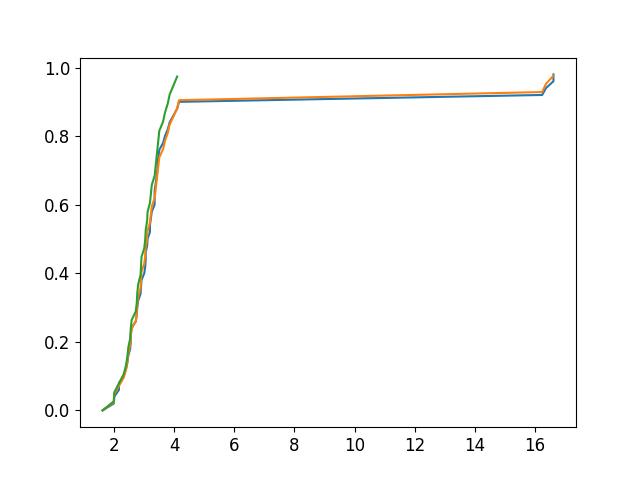

In [29]:
plt.figure()
plt.plot(midptsX,cdfX)
plt.plot(midptsY,cdfY)
plt.plot(midpts2,cdf2)

# Neural data figure

## Fiber velocities

### Myelinated

In [6]:
def getVelocitiesM(diameter,t1,t2,s1,s2):
    
    internodeDistance = 100 * diameter # in um
    
    numSections = s2-s1
    
    time = t2-t1 # in ms
    
    distance = (1 + internodeDistance) * numSections * 1e-6 # in m. Add 1 to account for node length
    
    v = distance / (time * 1e-3) # in m/s
    
    return v

In [7]:
v20 = getVelocitiesM(20,1.005,1.2275,42,52)
v10 = getVelocitiesM(10,0.9825,1.20625,42,52)
v5 = getVelocitiesM(5,0.9475,1.165,42,52)
v2 = getVelocitiesM(2,0.8725,1.0775,42,52)

diamsM = np.array([0,2,5,10,20])
vM = np.array([0,v2,v5,v10,v20])

### Unmyelinated

In [8]:
def getVelocities(t1,t2,s1,s2):
    
    sectionLength = 50 # in um
    
    numSections = s2-s1
    
    time = t2-t1 # in ms
    
    distance = sectionLength * numSections * 1e-6 # in m
    
    v = distance / (time * 1e-3) # in m/s
    
    return v

In [9]:
vp8 = getVelocities(10.1125,11.3,85,95)
vp4 = getVelocities(14.755,16.5175,85,95)
vp2 = getVelocities(22.387501,25.0625,85,95)
vp3 = getVelocities(17.455,19.537498,85,95)
vp6 = getVelocities(11.7975,13.1925,85,95)

diamsU = np.array([0,0.2,0.3,0.4,0.6,0.8])
vU = np.array([0,vp2,vp3,vp4,vp6,vp8])

## AP shape

In [10]:
def FitAPShape(ap,tphi): # Interpolates AP shape for a given AP
    
    
    # Ignores initial transient
    tv = ap.iloc[50:,0]
    v = ap.iloc[50:,1]
    
    ### Sets peak time to 0
    peak = tv[np.argmax(v)]
    tv -= peak


    apShapeEmpirical = v.values
        

    func = interp1d(tv,apShapeEmpirical,bounds_error=False,fill_value=(apShapeEmpirical[0],apShapeEmpirical[-1]))
    
    Vs = func(tphi)  
    
    
    #### Applies low-pass filter with very high cutoff, to remove artifacts
    sos = butter(1, 20000, 'lp', fs=83333, output='sos')
    
    V = sosfilt(sos,Vs)
    
    V[:10] = V[10]
         
    return V

### Myelinated

In [11]:
ap = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShape20.xlsx') # Rat

ap2 = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShape10.xlsx') # Rat

fitap = FitAPShape(ap,time)
fitap2 = FitAPShape(ap2,time)


### Unmyelinated

In [12]:
apU = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShapePoint8.xlsx') # Rat

apU2 = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/APShapePoint4.xlsx') # Rat

fitapU = FitAPShape(apU,time)
fitapU2 = FitAPShape(apU2,time)


## Thresholds

### Myelinated

In [13]:
thresholds = np.array([8.0625,3.40625,2.23438,1.71875,1.45313,1.28906,1.17188,1.03906,0.945313])
diameters = np.array([1,2,3,4,5,6,7,8,9])

thresholds *= 178


### Unmyelinated

In [14]:
thresholdsU = np.array([552,280,189,143,116,97,84,74,66.5])
diametersU = np.array([1,2,3,4,5,6,7,8,9])*0.1

thresholdsU *= 178


In [15]:
vM

array([ 0.        ,  9.80487805, 23.03448276, 44.73743017, 89.93258427])

## Plots everything

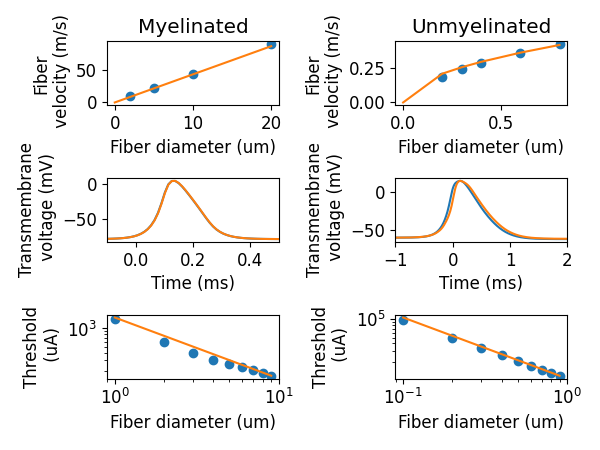

In [15]:
plt.figure(figsize=(6,4.5))

plt.subplot(3,2,1) # velocity, myelinated

plt.title('Myelinated')

plt.plot(diamsM[1:],vM[1:],'o')
plt.plot(diamsM,86.95*diamsM/20)
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Fiber\n velocity (m/s)')

plt.tight_layout()

plt.subplot(3,2,2) # Velocity, unmyelinated

plt.title('Unmyelinated')

plt.plot(diamsU[1:],vU[1:],'o')
plt.plot(diamsU,0.416*np.sqrt(diamsU/0.8))
plt.xlabel('Fiber diameter (um)')
plt.ylabel('Fiber\n velocity (m/s)')


plt.tight_layout()

plt.subplot(3,2,3) # AP shape, myelinated

plt.plot(time*1e3, fitap*1e3)
plt.plot(time*1e3, fitap2*1e3)

plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane\n voltage (mV)')

plt.xlim([-.1,.5])

plt.tight_layout()

plt.subplot(3,2,4) # AP shape, unmyelinated

plt.plot(time*1e3, fitapU*1e3)
plt.plot(time*1e3, fitapU2*1e3)

plt.xlabel('Time (ms)')
plt.ylabel('Transmembrane\n voltage (mV)')

plt.xlim([-1,2])

plt.tight_layout()

plt.subplot(3,2,5) # Threshold, myelinated

plt.loglog(diameters,thresholds,'o')
plt.loglog(diameters,thresholds[-1]*diameters[-1]/diameters)

plt.xlabel('Fiber diameter (um)')
plt.ylabel('Threshold\n (uA)')

plt.tight_layout()

plt.subplot(3,2,6) # Threshold, unmyelinated

plt.loglog(diametersU,thresholdsU,'o')
plt.loglog(diametersU,thresholdsU[-1]*diametersU[-1]/diametersU)

plt.xlabel('Fiber diameter (um)')
plt.ylabel('Threshold\n (uA)')

plt.tight_layout()

# plt.savefig('figures/dataFigure.png',dpi=600)


# Fiber type diameter distributions

In [17]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic-test'

dist = []
for i in range(39):
    dist.append(np.load(outputfolder+'/'+str(iteration)+'/fascicles/probDist'+str(i)+'.npy',allow_pickle=True))
    

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic-test/0/fascicles/probDist0.npy'

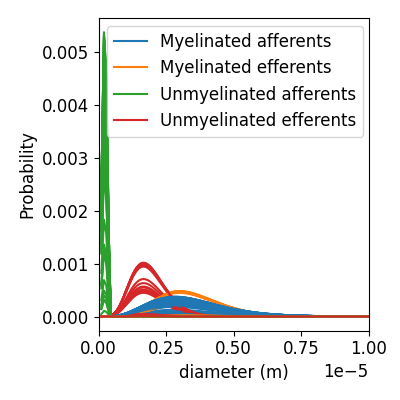

In [18]:
plt.figure(figsize=(4,4))

for i in range(39):
    plt.plot(d,dist[i][0],c='tab:blue')
    plt.plot(d,dist[i][1],c='tab:orange')
    plt.plot(d,dist[i][2],c='tab:green')
    plt.plot(d,dist[i][3],c='tab:red')

plt.legend(['Myelinated afferents','Myelinated efferents','Unmyelinated afferents','Unmyelinated efferents'])
plt.xlim([0,1e-5])
plt.xlabel('diameter (m)')
plt.ylabel('Probability')
plt.tight_layout()

plt.savefig('figures/distribution.png',dpi=600)

# Signal as a function of stimulus amplitude

### Horizontal electrode, high perineuria conductivity, large separation between recording electrodes, 6 cm from stimulus to recording electrode

In [18]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic-test'

distanceIdx = 0 # 6 cm

maffAll = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    maffAll = np.vstack((maffAll,np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))
    
meffAll = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    meffAll = np.vstack((meffAll,np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

uaffAll = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    uaffAll = np.vstack((uaffAll,np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals_'+str(i)+'.npy')[np.newaxis]))

ueffAll = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(0)+'/signals_0.npy')[np.newaxis]

for i in np.arange(1,39):
    ueffAll = np.vstack((ueffAll,np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(0)+'/signals_'+str(i)+'.npy')[np.newaxis]))

totalAll = maffAll + meffAll+ uaffAll + ueffAll



In [19]:
signals = np.sum(totalAll,axis=0)

In [21]:
recruitment = []
for i in range(39):
    recruitment.append(np.load(outputfolder+'/'+str(iteration)+'/recruitment/recruitment_'+str(i)+'.npy',allow_pickle=True))
    

In [22]:
signals.shape

(5, 499997)

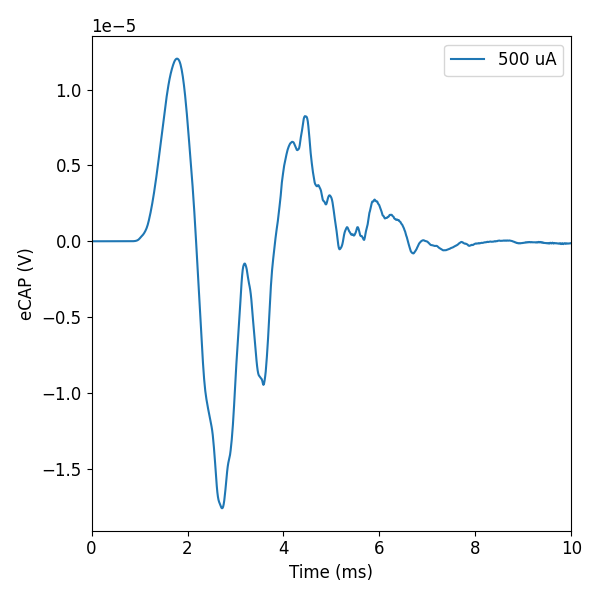

In [21]:
plt.figure(figsize=(6,6))

legend = []

    
plt.plot(time[1:-1]*1e3,signals[-1])
legend.append(str(np.round(currents[-1]))+' uA')

plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([0,10])
plt.tight_layout()

# plt.savefig('figures/shape_amplitude.png',dpi=600)

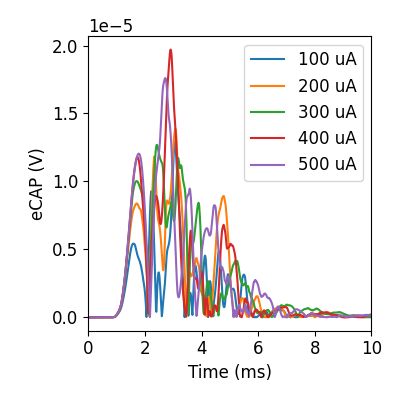

In [24]:
plt.figure(figsize=(4,4))

legend = []

for i in np.arange(0,5,1):
    
    plt.plot(time[1:-1]*1e3,np.sqrt(signals[i]**2))
    legend.append(str(np.round(currents[i]))+' uA')

plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([0,10])
plt.tight_layout()

# Peak-to-peak signal amplitude as function of stimulus amplitude

### Same parameters as above

In [25]:
amplitudes = np.max(signals[:,tIndex],axis=1)-np.min(signals[:,tIndex],axis=1)

In [26]:
currents.shape

(5,)

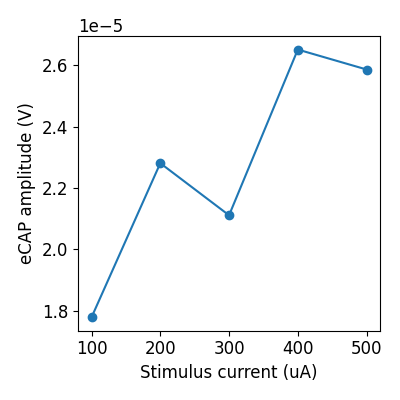

In [27]:
plt.figure(figsize=(4,4))

plt.plot(currents,amplitudes,'-o')

plt.xlabel('Stimulus current (uA)')
plt.ylabel('eCAP amplitude (V)')

plt.tight_layout()

plt.savefig('figures/amplitudes.png',dpi=600)

# Correlations between different fascicles
### Same recording parameters as above
### 500 uA stimulus current

In [28]:
from sklearn.cluster import SpectralCoclustering 

In [29]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [30]:
smooth = savitzky_golay(totalAll[0,-1,tIndex],11,1)

for i in np.arange(1,39):
    smooth = np.vstack((smooth,savitzky_golay(totalAll[i,-1,tIndex],11,1)))


/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2331869/ipykernel_219376/2858922972.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2331869/ipykernel_219376/2858922972.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

In [31]:
normalizedSignals = totalAll[:,-1,tIndex]/np.mean(np.sqrt(totalAll[:,-1,tIndex]**2),axis=0)



# normalizedSignals = smooth/np.mean(np.sqrt(smooth**2),axis=0)


In [32]:
correlations = np.corrcoef( smooth )



correlations = np.corrcoef(normalizedSignals)



In [33]:
nclusters = 4

In [34]:
model = SpectralCoclustering(n_clusters=nclusters, random_state=0)
model.fit(correlations)

SpectralCoclustering(n_clusters=4, random_state=0)

In [35]:
fit_data = correlations[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

In [36]:
print(np.argsort(model.row_labels_)[:12])
print(np.argsort(model.row_labels_)[12:32])
print(np.argsort(model.row_labels_)[32:34])
print(np.argsort(model.row_labels_)[34:])

[38 17 16 27 11 37  9 29 31  5  1  7]
[30 32 28 34 25 24 36 23 22  0 20  3  4 21 12  8 14 18 13 19]
[10 33]
[26  6 15 35  2]


In [37]:
s = np.sort(model.row_labels_)
for i in range(4):
    print(np.where(s==i))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)
(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31]),)
(array([32, 33]),)
(array([34, 35, 36, 37, 38]),)


In [38]:
s = np.sort(model.column_labels_)
for i in range(4):
    print(np.where(s==i))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),)
(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31]),)
(array([32, 33]),)
(array([34, 35, 36, 37, 38]),)


### RGB values based on cluster for each fascicle

In [39]:
rgbs = []

rgbList = [np.array([31,119,180])/255,np.array([255,127,14])/255,np.array([44,160,44])/255,np.array([214,39,40])/255]

for label in model.row_labels_:

    rgbs.append(rgbList[label])

np.save('figures/clusterRGB.npy',rgbs)

    

## Raw correlations

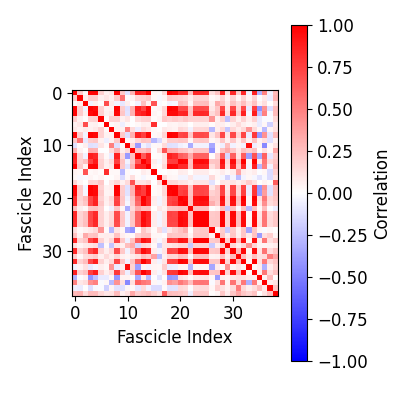

In [40]:
fig, ax = plt.subplots(figsize=(4,4))

plot = plt.imshow(correlations, cmap=plt.cm.bwr,vmin=-1,vmax=1)

fig.colorbar(plot, label='Correlation')
plt.xlabel('Fascicle Index')
plt.ylabel('Fascicle Index')
plt.tight_layout()

## Correlations sorted by cluster
## Signals from each fascicle and recruitment curves, colored by cluster

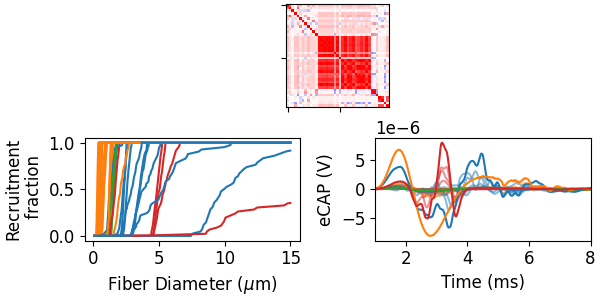

In [41]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])

plot = ax0.imshow(fit_data, cmap=plt.cm.bwr,vmin=-1,vmax=1,interpolation='None')
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# plt.xticks(np.arange(39),np.argsort(model.row_labels_))
# plt.yticks(np.arange(39),np.argsort(model.row_labels_))

# fig.colorbar(plot, label='Correlation',location='right',fraction=0.05)
# plt.xlabel('Fascicle Index')
# plt.ylabel('Fascicle Index')

for i in range(39):

    ax1.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.row_labels_[i]))
    
    ax1.set_xlabel('Fiber Diameter ($\mu$m)')
    ax1.set_ylabel('Recruitment\n fraction')
    
    
    ax2.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.row_labels_[i]),alpha=0.5)

    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('eCAP (V)')

    ax2.set_xlim([1,8])

for i in np.unique(model.row_labels_):

    meanSignal = np.sum(totalAll[model.row_labels_==i,-1],axis=0)

    ax2.plot(time[1:-1]*1e3,meanSignal,c='C'+str(i))
    

plt.savefig('figures/correlations.png',dpi=600)

In [42]:
totalAll[model.row_labels_==i,-1].shape

(5, 499997)

## Same as above, but with colorbar

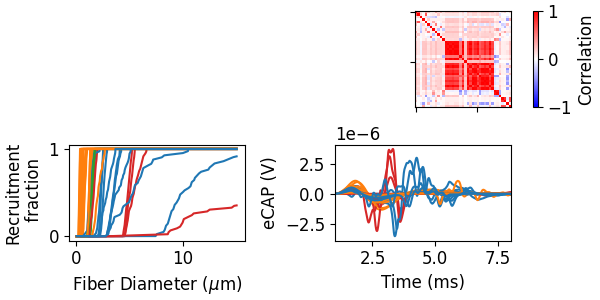

In [43]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])

plot = ax0.imshow(fit_data, cmap=plt.cm.bwr,vmin=-1,vmax=1,interpolation='None')
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# plt.xticks(np.arange(39),np.argsort(model.row_labels_))
# plt.yticks(np.arange(39),np.argsort(model.row_labels_))

fig.colorbar(plot, label='Correlation',location='right',fraction=0.05)
# plt.xlabel('Fascicle Index')
# plt.ylabel('Fascicle Index')

for i in range(39):

    ax1.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.row_labels_[i]))
    
    ax1.set_xlabel('Fiber Diameter ($\mu$m)')
    ax1.set_ylabel('Recruitment\n fraction')
    
    
    ax2.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.row_labels_[i]))

    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('eCAP (V)')

    ax2.set_xlim([1,8])
    

plt.savefig('figures/correlations_colorbar.png',dpi=600)

## Same as aobove, but with each fascicle plotted in a different figure

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2331869/ipykernel_219376/780449813.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


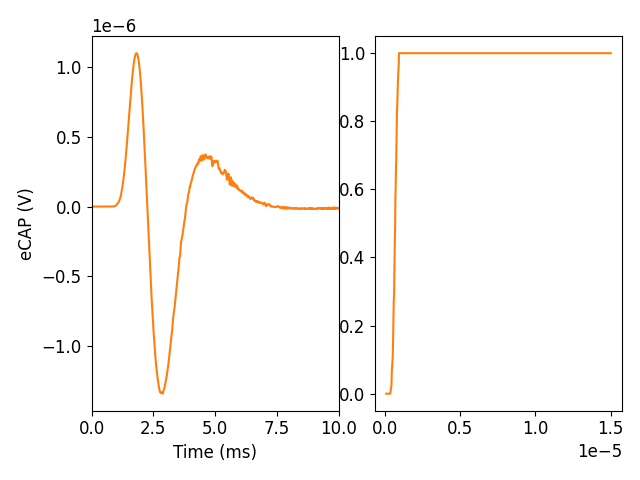

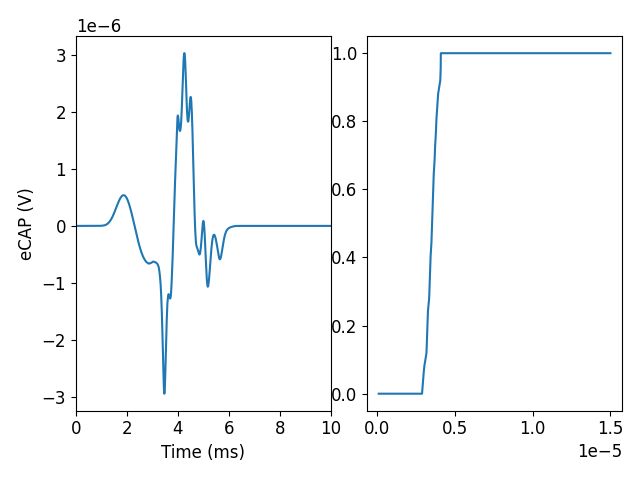

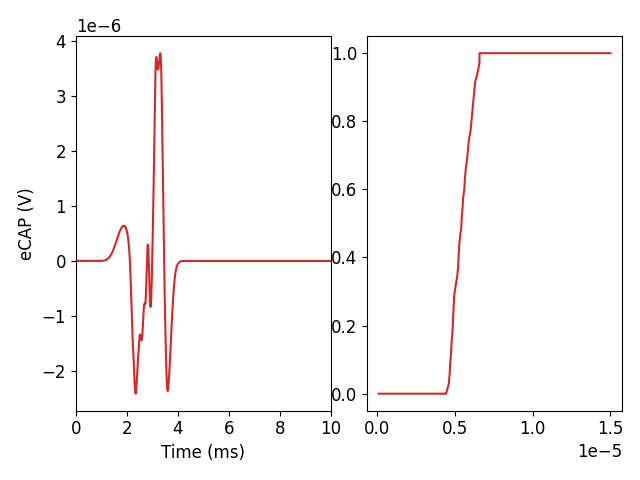

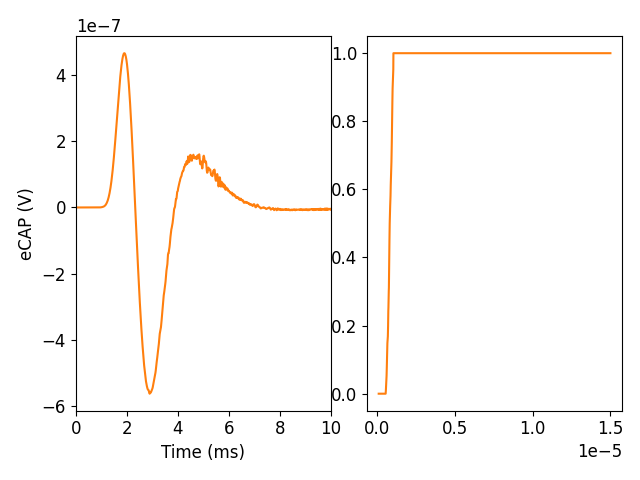

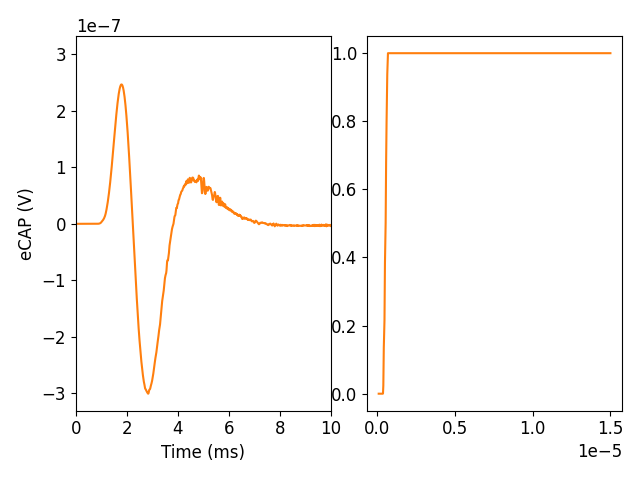

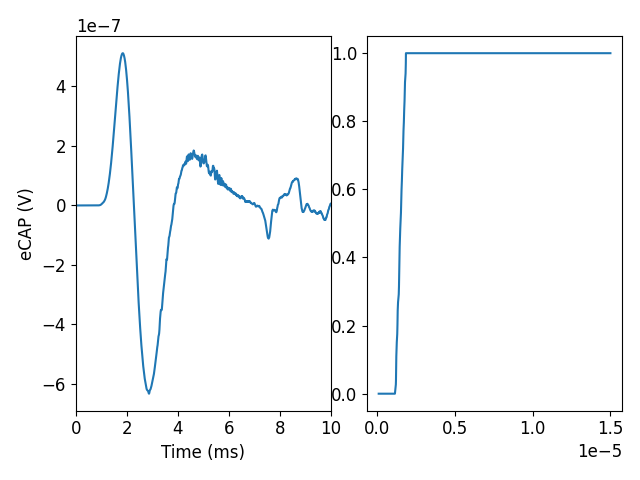

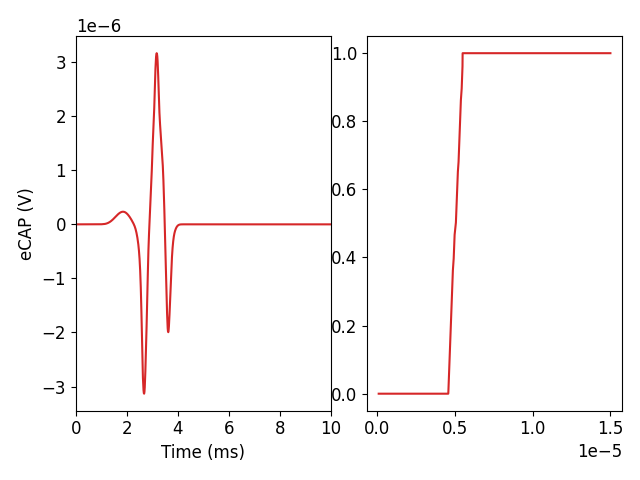

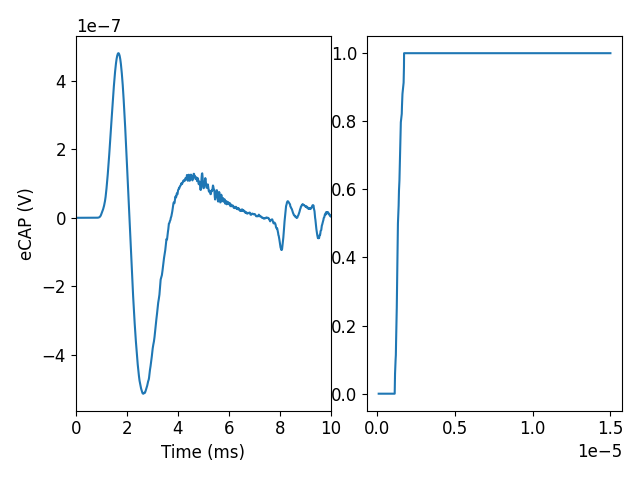

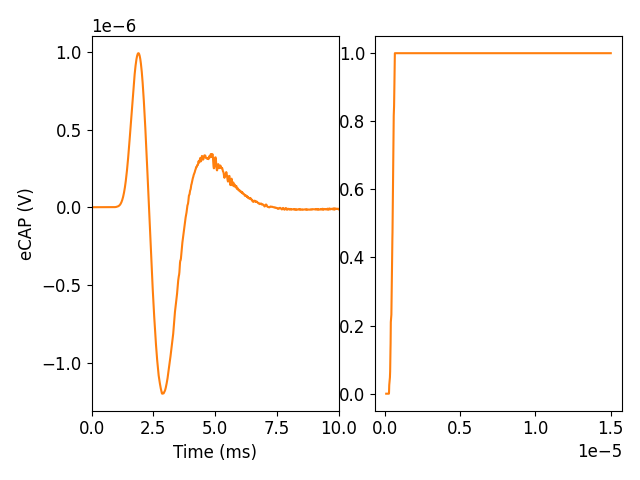

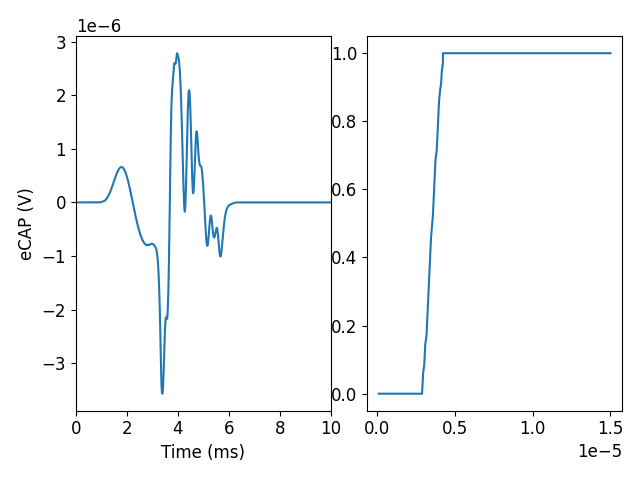

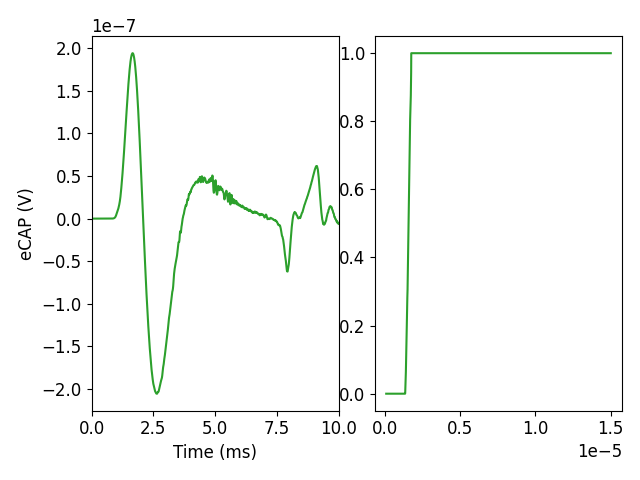

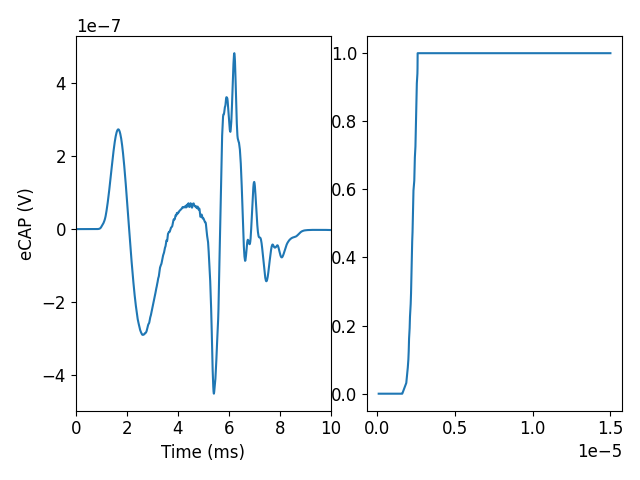

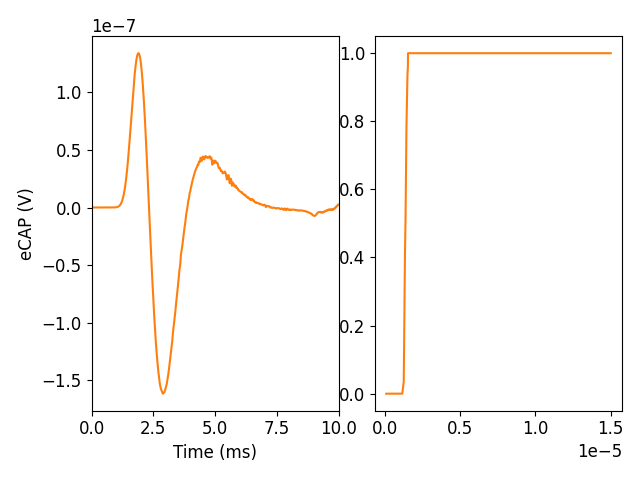

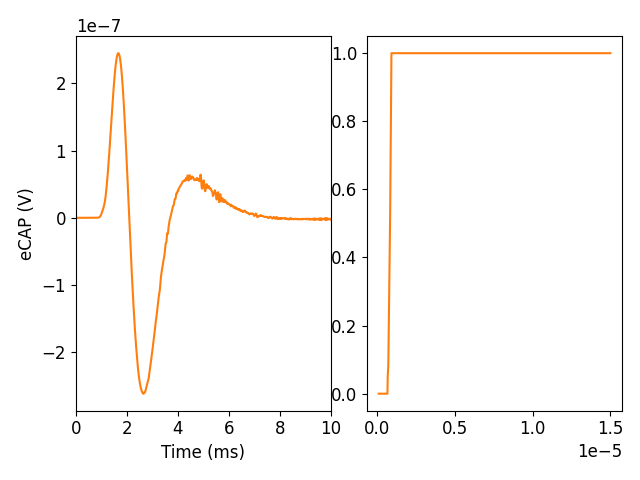

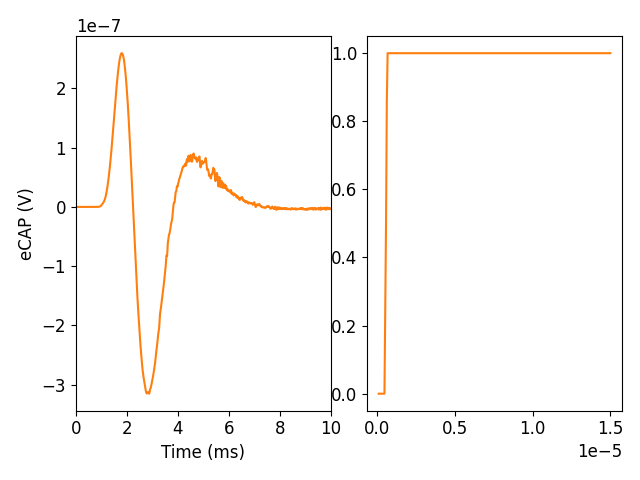

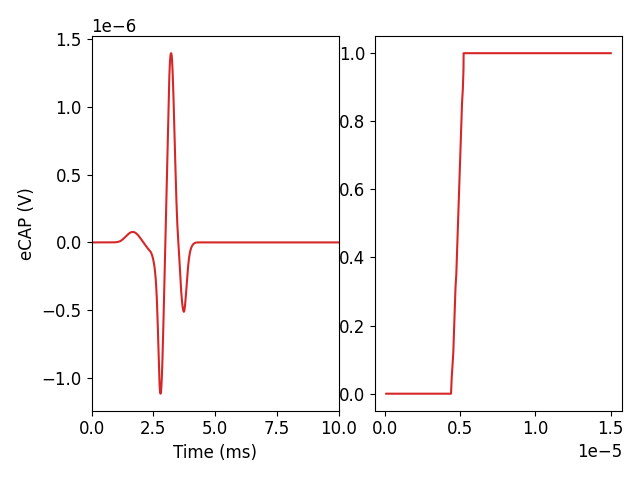

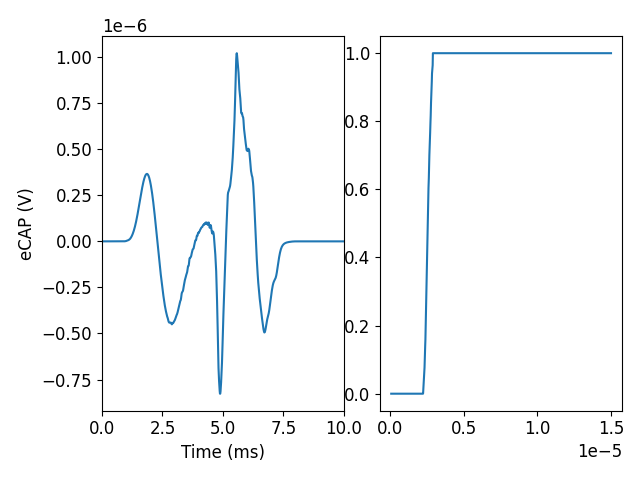

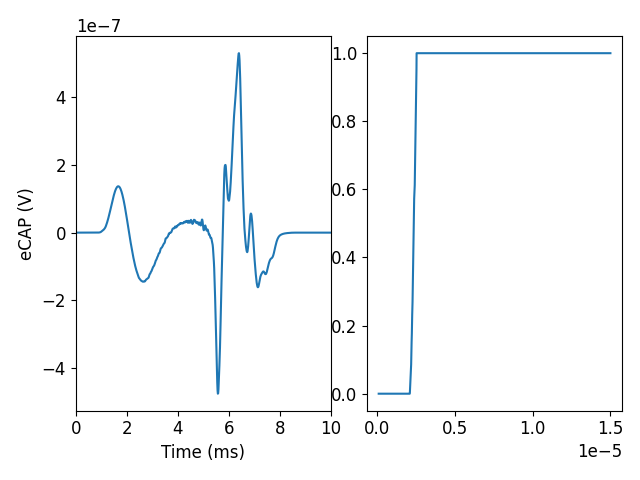

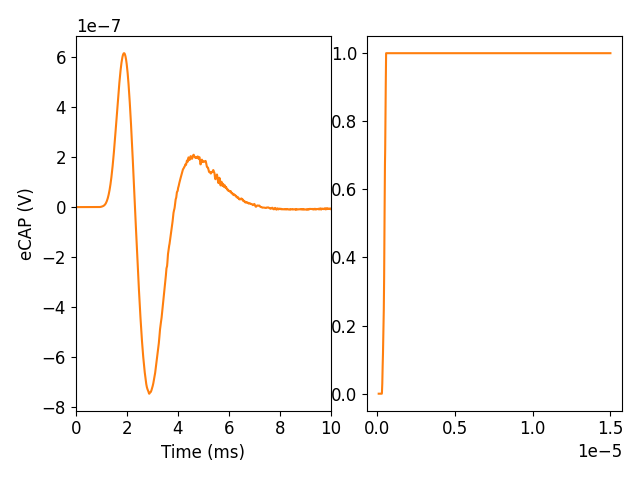

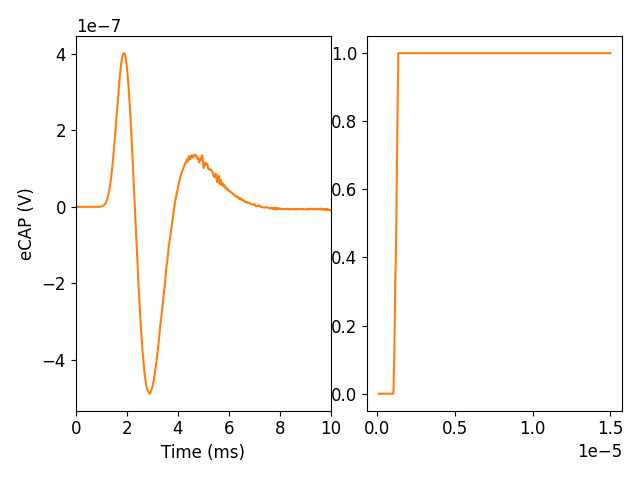

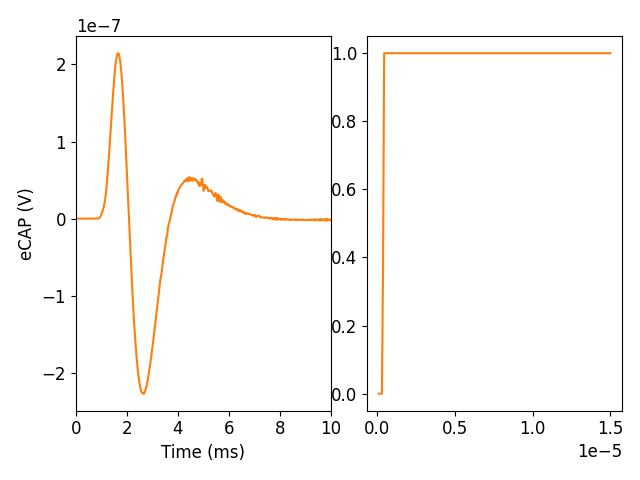

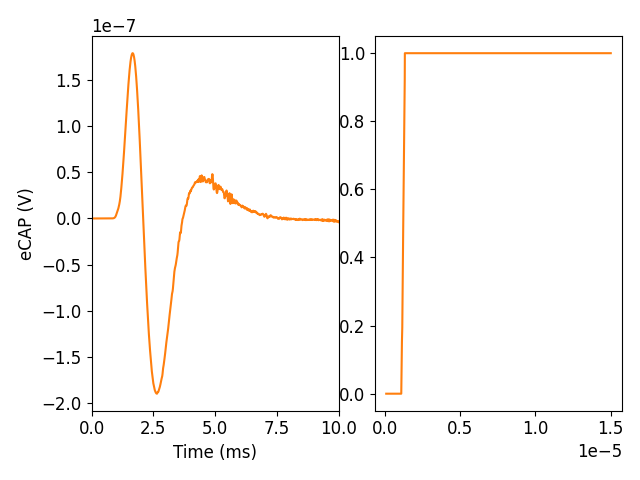

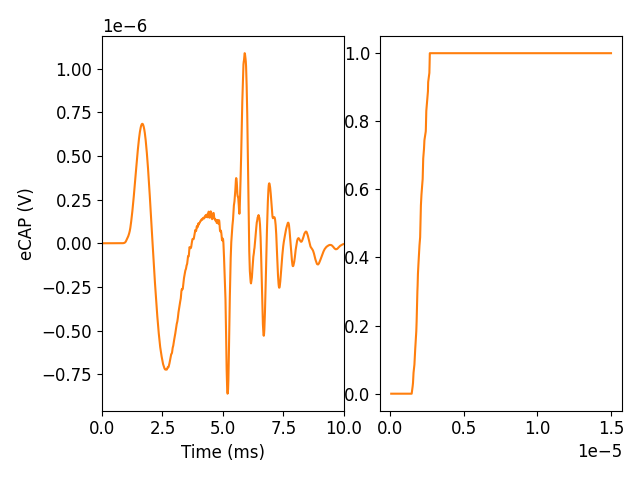

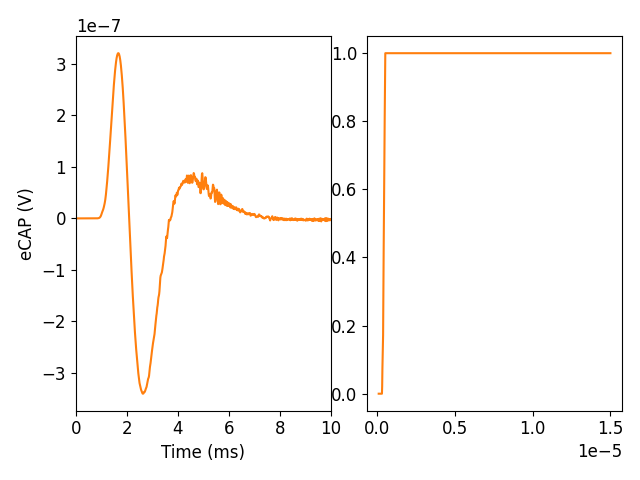

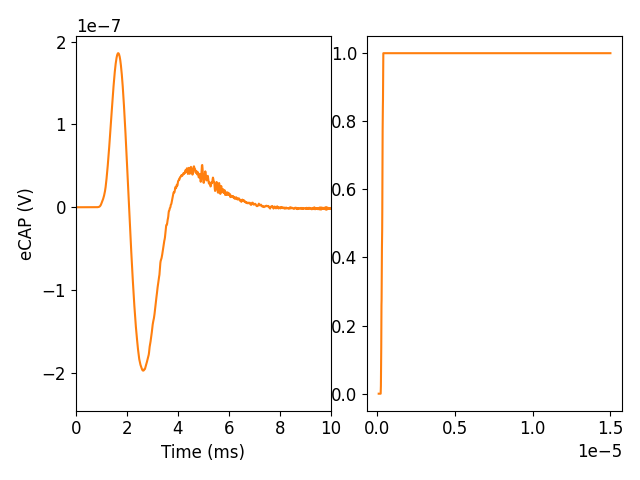

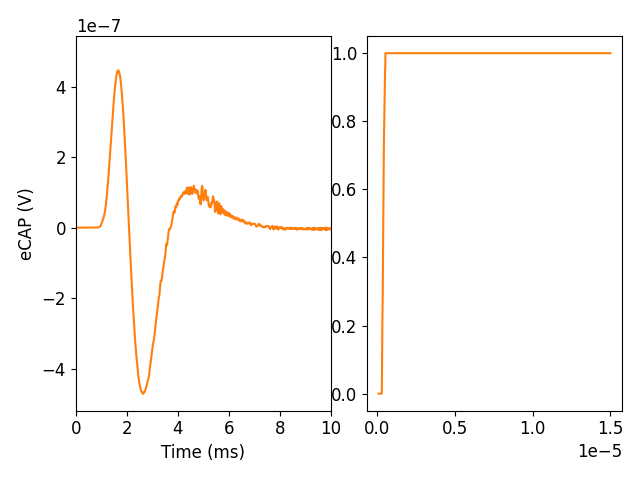

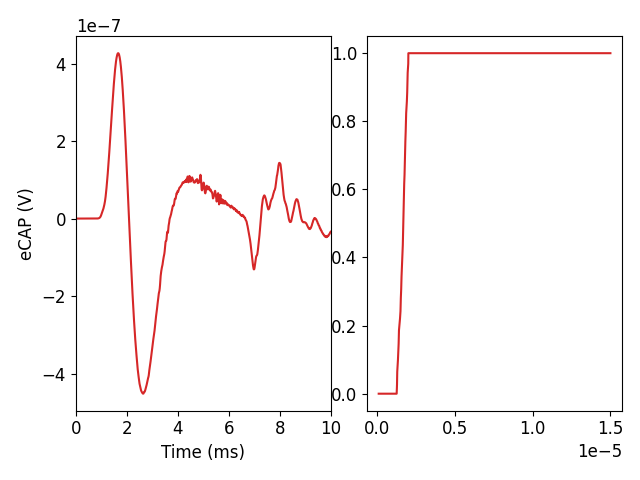

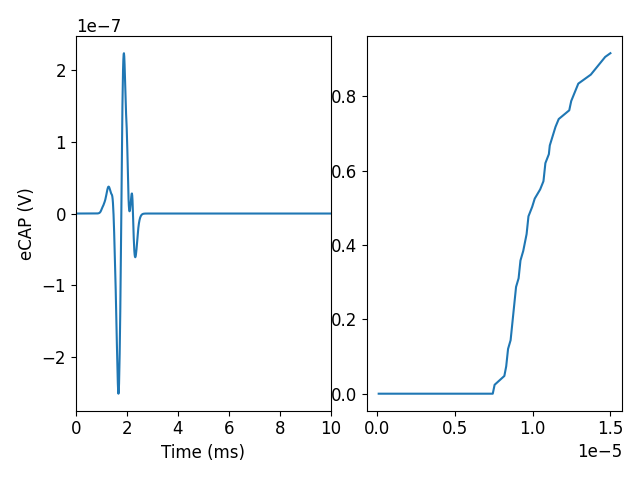

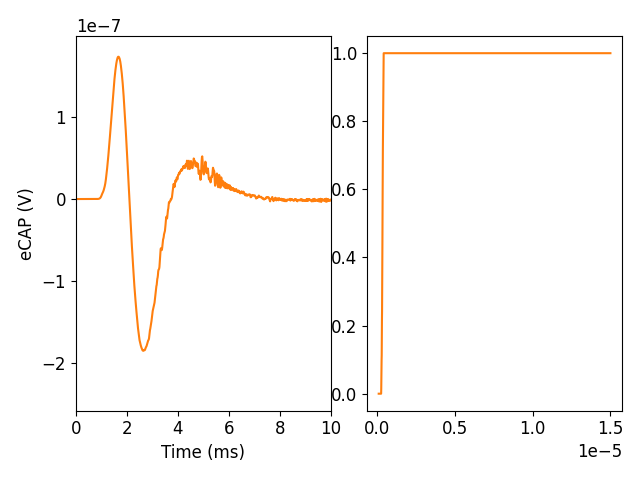

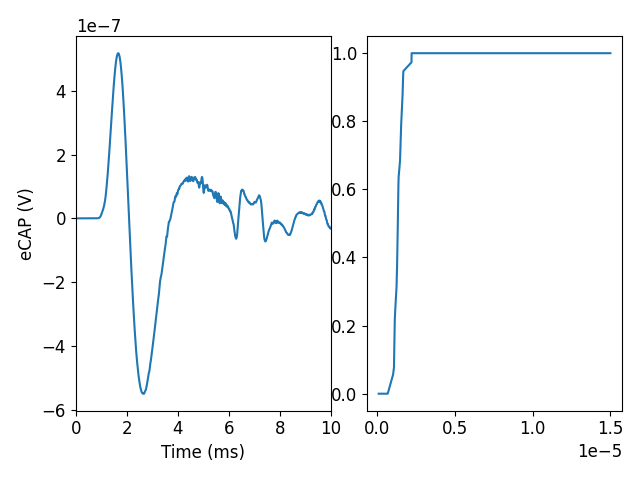

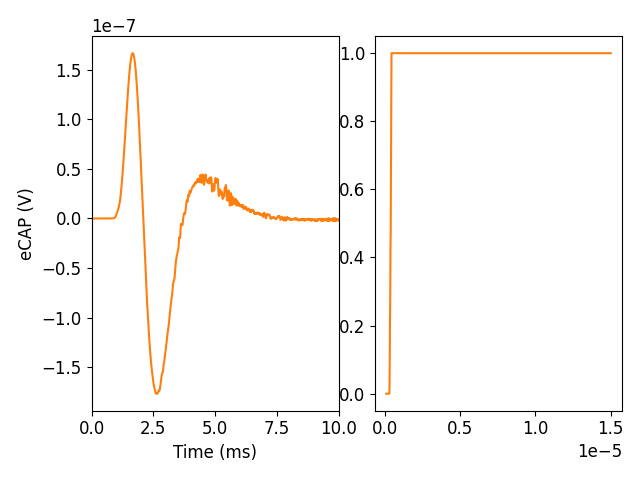

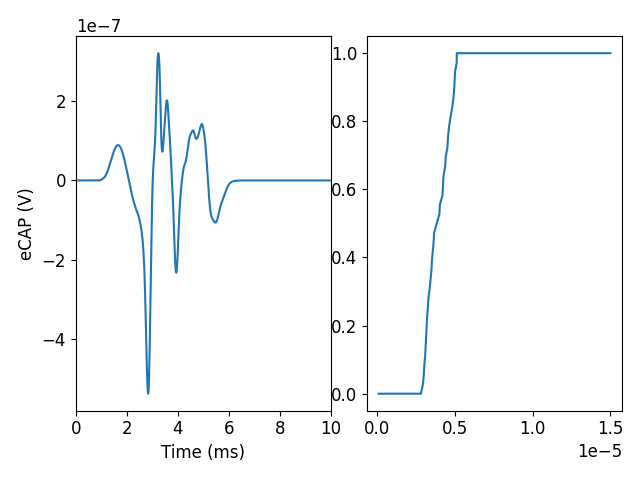

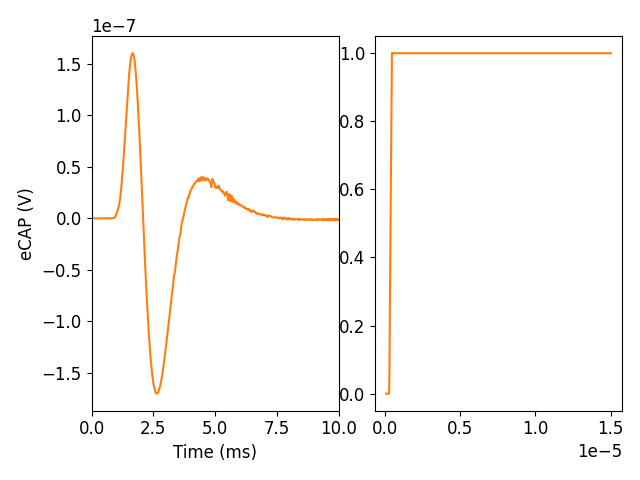

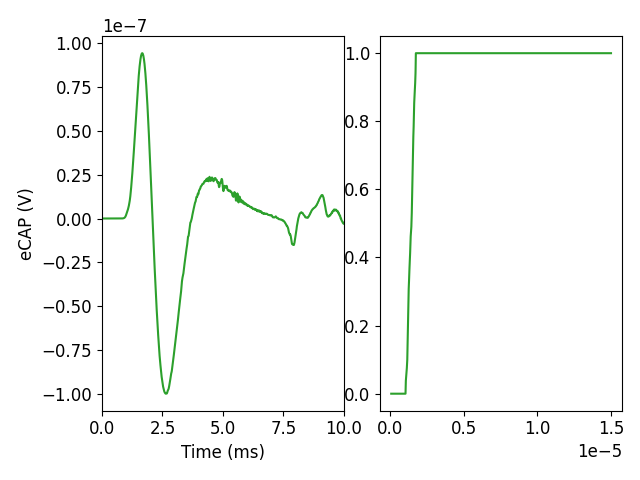

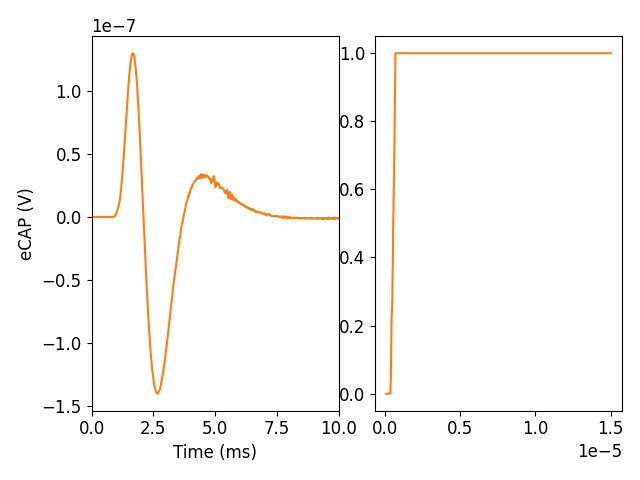

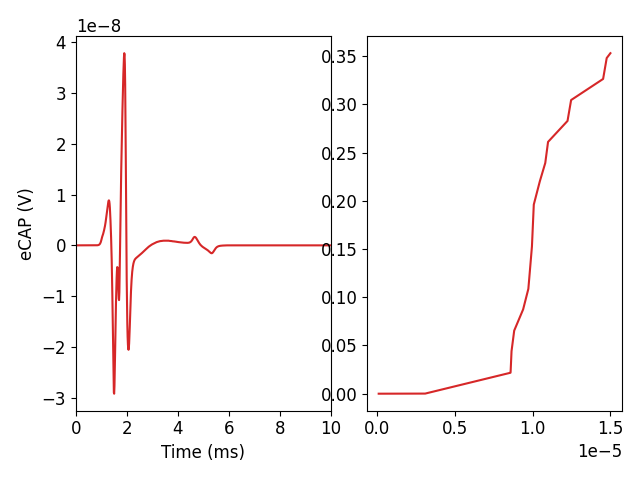

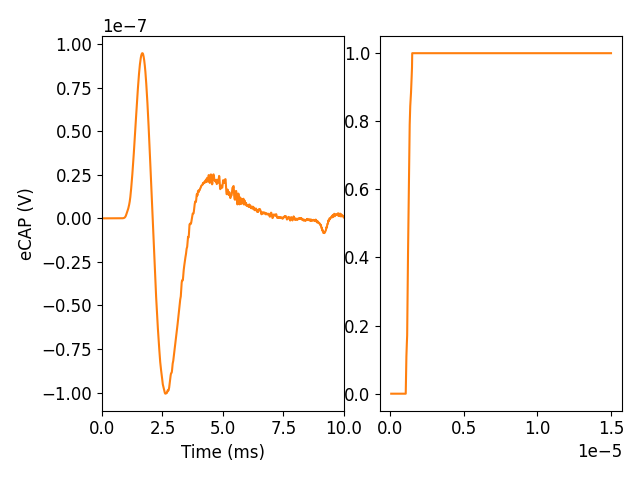

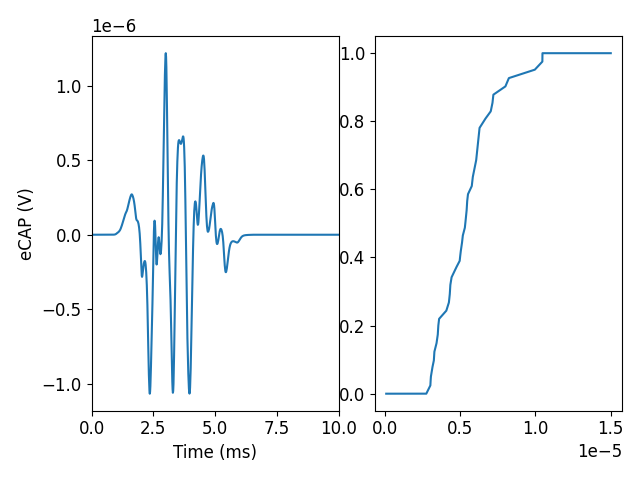

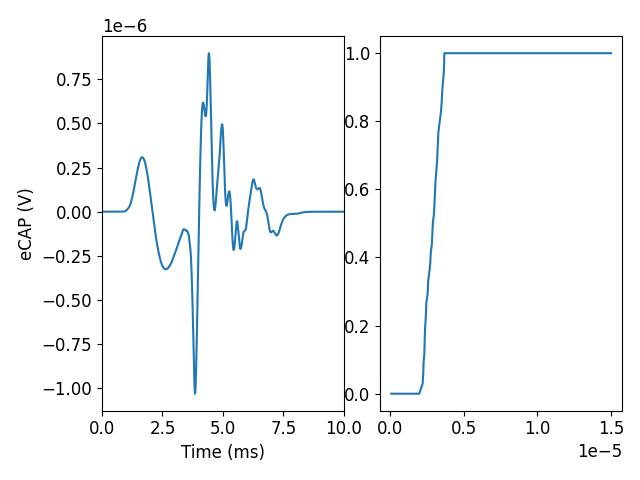

In [44]:
for i in range(39):
    plt.figure()
    plt.subplot(1,2,1)
    
    plt.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.row_labels_[i]))

    plt.xlabel('Time (ms)')
    plt.ylabel('eCAP (V)')

    plt.xlim([0,10])
    
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(d,recruitment[i][-1][0],c='C'+str(model.row_labels_[i]))

## Fascicle contributions and recruitment curves, plotted separately for each cluster

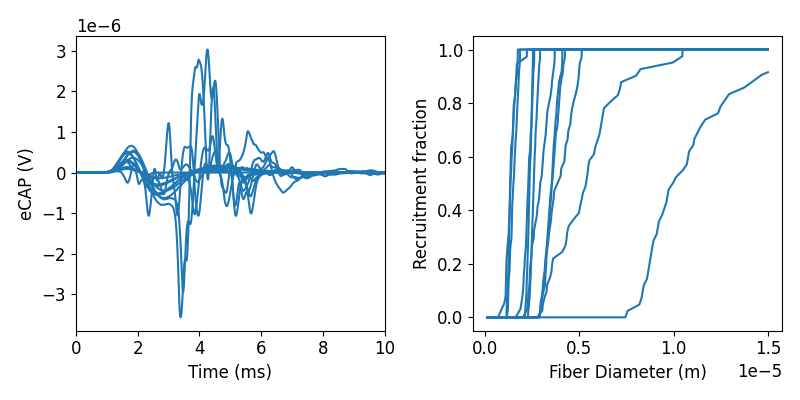

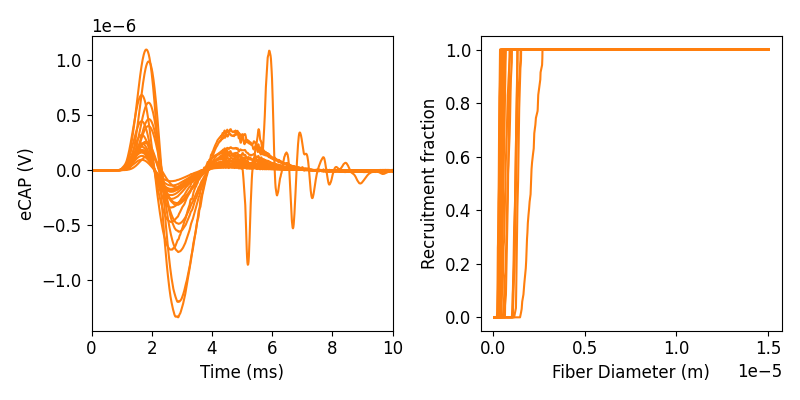

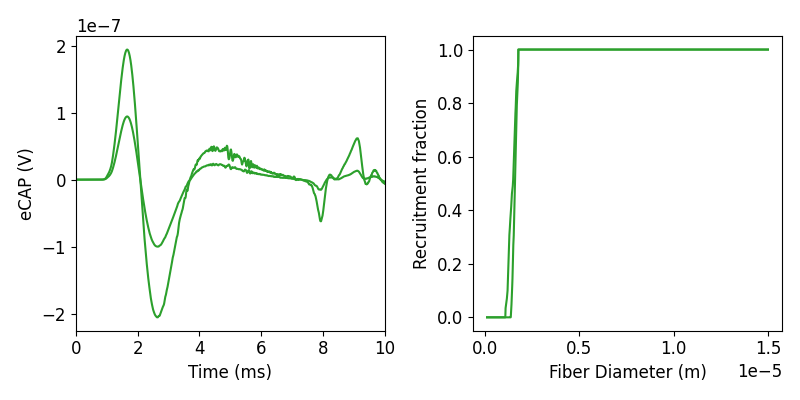

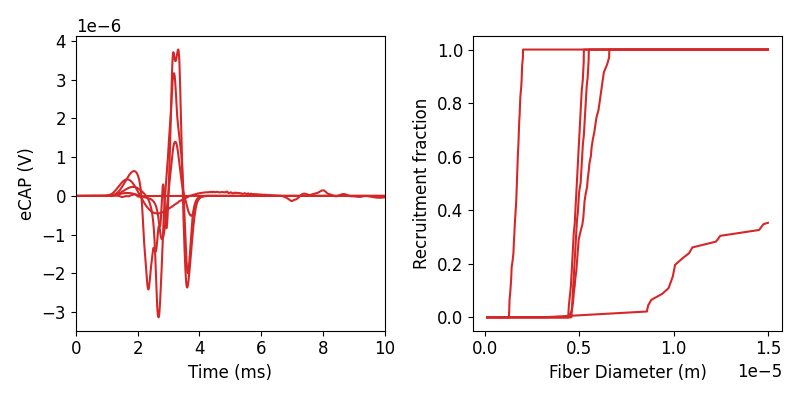

In [45]:

for cluster in range(nclusters):

    plt.figure(figsize=(8,4))

    for i in range(39):

        if model.row_labels_[i]==cluster:

            plt.subplot(1,2,1)


            plt.plot(time[1:-1]*1e3,totalAll[i,-1],c='C'+str(model.row_labels_[i]))

            plt.xlabel('Time (ms)')
            plt.ylabel('eCAP (V)')

            plt.xlim([0,10])

            plt.tight_layout()

            plt.subplot(1,2,2)
            plt.plot(d,recruitment[i][-1][0],c='C'+str(model.row_labels_[i]))

            plt.xlabel('Fiber Diameter (m)')
            plt.ylabel('Recruitment fraction')
            plt.tight_layout()

# Examples

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2331869/ipykernel_219376/314274452.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


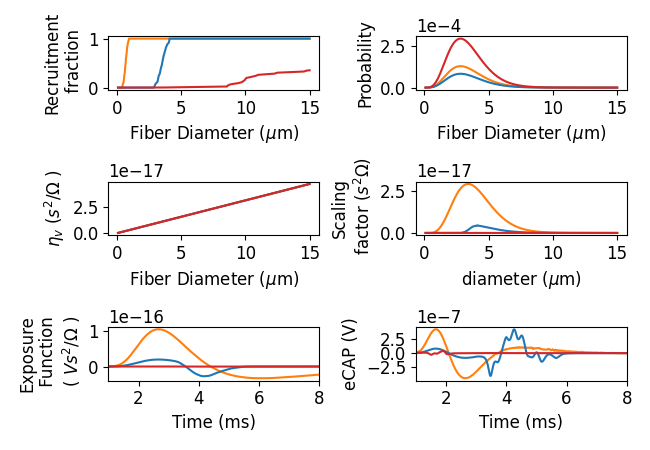

In [46]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6.5,4.5),constrained_layout=True)

gs = GridSpec(3,6,figure=fig)

ax0 = fig.add_subplot(gs[0,:3])
ax1 = fig.add_subplot(gs[0,3:])
ax2 = fig.add_subplot(gs[1,:3])

ax3 = fig.add_subplot(gs[1,3:])
ax4 = fig.add_subplot(gs[2,:3])

ax5 = fig.add_subplot(gs[2,3:])

selections = [0,1,35]

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic'

for i in selections:
    
    ax0.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.row_labels_[i]))

    ax0.set_xlabel('Fiber Diameter ($\mu$m)')
    ax0.set_ylabel('Recruitment\n fraction')

    ax1.plot(d*1e6,dist[i][0],c='C'+str(model.row_labels_[i]))
    # ax1.set_xlim([0,10])
    ax1.ticklabel_format(axis='y',scilimits=[0,0])
    ax1.set_xlabel('Fiber Diameter ($\mu$m)')
    ax1.set_ylabel('Probability')

    scaling = np.load(outputfolder+'/0/diameters/scaling_'+str(i)+'.npy')

    ax2.plot(d*1e6,scaling[0],c='C'+str(model.row_labels_[i]))
    # ax2.set_xlim([0,10])
    ax2.set_xlabel('Fiber Diameter ($\mu$m)')
    ax2.set_ylabel('$\eta_v$ ($ s^2 / \Omega$ )')

    scaling = np.load(outputfolder+'/0/maff/0/scaling_'+str(i)+'.npy',allow_pickle=True)

    ax3.plot(d*1e6,scaling[:,-1],c='C'+str(model.row_labels_[i]))
    # ax3.set_xlim([0,10])
    ax3.set_xlabel('diameter ($\mu$m)')
    ax3.set_ylabel('Scaling\n factor ($ s^2 \Omega $)')

    phi = np.load(outputfolder+'/0/phis/0/'+str(i)+'.npy',allow_pickle=True)

    ax4.plot(time*1e3,phi[0,:,-1],c='C'+str(model.row_labels_[i]))
    ax4.set_xlim([1,8])
    ax4.set_xlabel('Time (ms)')
    ax4.set_ylabel('Exposure\n Function\n ( $ V s^2/\Omega $ )')
        
    ax5.plot(time[1:-1]*1e3,maffAll[i,-1],c='C'+str(model.row_labels_[i]))
    ax5.set_xlabel('Time (ms)')
    ax5.set_ylabel('eCAP (V)')
    ax5.set_xlim([1,8])

plt.tight_layout()
plt.savefig('figures/example.png',dpi=600)
    

In [47]:
def editPhiShape(phi,distance):
    
    ''' 
    This function takes the recording exposure curve from S4L, shifts it to match the desired distance from stimulus to recording, and smooths it
    '''
    
    xvals = phi.iloc[:,0].values+distance -phi.iloc[np.argmax(phi.iloc[:,1].values),0] # Shift to match desired distance

    phiShapeEmpirical = phi.iloc[:,1].values-np.mean(phi.iloc[:,1])

    
   ######## 
    
    ####### Makes sure that the potential at the proximal end of the fiber goes all the way to zero

    if np.any(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0): # If the potential is negative at the end of the fiber, sets the potential to 0
        
        
        first = np.where(phiShapeEmpirical[:np.argmax(phiShapeEmpirical)]<0)[0][-1]    
        
        phiShapeEmpirical[:first] = 0
        
    else: # If the potential does not go all the way to 0 by the end of the fiber, forces it to zero
        
        first = np.where(np.abs(np.diff(phiShapeEmpirical))>1e-4)[0][0] # Based on derivative of function, selects point after whcih not to change values
        

        ### Linearizes potential before this point, up until it reaches 0 
        firsta = np.where(phiShapeEmpirical[first]-1e-4*np.arange(first)<0)[0][0]
        firsta = first-firsta

        phiShapeEmpirical[firsta:first] = 1e-4*np.arange(first-firsta)
        #######
        
        phiShapeEmpirical[0:firsta]=0 # Sets potential to zero
        
    ############
   
    #### Does the same kind of smoothing as above, but for the distal end fo the fiber
    if np.any(phiShapeEmpirical[np.argmin(phiShapeEmpirical):]>0):
                
        last = np.where(phiShapeEmpirical[np.argmin(phiShapeEmpirical):]>0)[0][0]+np.argmin(phiShapeEmpirical)
        
        phiShapeEmpirical[last:] = 0
        
    else:
        last = np.where(np.abs(np.diff(phiShapeEmpirical))>1e-4)[0][-1]
        lasta = np.where(phiShapeEmpirical[last]+1e-4*np.arange(len(phiShapeEmpirical)-last)>0)[0][0]
        lasta += last

        phiShapeEmpirical[last:lasta] = 1e-4* np.arange(lasta-last)+ phiShapeEmpirical[last]
        phiShapeEmpirical[lasta:] = 0
    

    return xvals, phiShapeEmpirical

def FitPhiShape(fascIdx,distance):
    
    ''' 
    This function creates an interpolation object for the recording exposure
    '''

    phi = pd.read_excel('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/'+str(fascIdx)+'_BetterConductivity.xlsx')
    
    xvals, phiShapeEmpirical = editPhiShape(phi,distance)

    return interp1d(xvals,phiShapeEmpirical,bounds_error=False,fill_value=(phiShapeEmpirical[0],phiShapeEmpirical[-1]))

def PhiShape(velocity,t,function):
    
    
    '''
    This function stretches the recording exposure in time, based on fiber velocity
    '''

    phiOut = []
    
#     sos = butter(1, 20000, 'lp', fs=83333, output='sos') # We apply a low-pass filter to avoid numerical issues

    for i, v in enumerate(velocity): # Iterates through fibers

        x = t*v ### Defines interpolation points from time vector and fiber velocity

        out = function(x)
            
#         filtered = sosfilt(sos,out)


        phiOut.append(out)

    return np.array(phiOut)

def getVelocities(d0List,velocities,dList):

    velocityList = []

    for i, d in enumerate(d0List):
        
        if i < 1: # Myelinated velocities are linear with diameter
            d0 = d0List[0]
            v0 = velocities[0]
            
            velocity = v0 * dList/d0
            
        else: # Unmyelinated velocities go as the square root of diameter
            d0 = d0List[1]
            v0 = velocities[1]
            
            velocity = v0 * np.sqrt(dList/d0)

        
        velocityList.append(velocity)

    return velocityList

In [48]:
d0List = [20*1e-6,0.8*1e-6] # Diameters of myelinated and unmyelinated fibers used to calculate velocities

velocities = [86.95,0.416] # Velcities for the above diamters
velocityList = getVelocities(d0List,velocities,d) # Gets velocity for each diameter


## Plots them all on seperate figures:

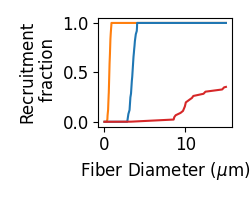

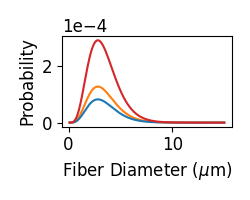

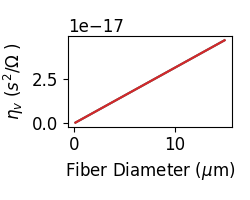

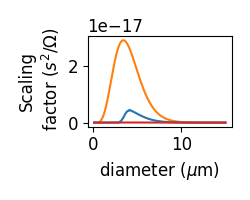

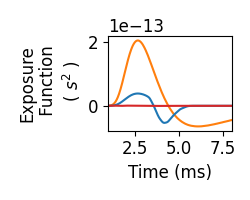

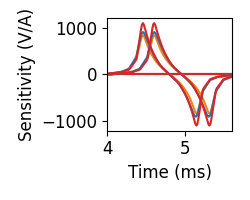

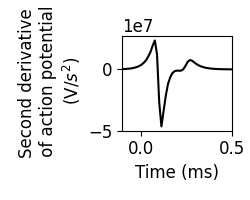

In [49]:
from matplotlib.gridspec import GridSpec

selections = [0,1,35]

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic'

plt.figure(figsize=(2.5,2))

for i in selections:

    ax = plt.gca()
    
    ax.plot(d*1e6,recruitment[i][-1][0],c='C'+str(model.row_labels_[i]))

ax.set_xlabel('Fiber Diameter ($\mu$m)')
ax.set_ylabel('Recruitment\n fraction')

plt.tight_layout()

plt.savefig('figures/example/recruitment.png',dpi=600)

plt.figure(figsize=(2.5,2))

for i in selections:
    
    ax1 = plt.gca() 

    ax1.plot(d*1e6,dist[i][0],c='C'+str(model.row_labels_[i]))
    # ax1.set_xlim([0,10])
ax1.ticklabel_format(axis='y',scilimits=[0,0])
ax1.set_xlabel('Fiber Diameter ($\mu$m)')
ax1.set_ylabel('Probability')
plt.tight_layout()

plt.savefig('figures/example/probability.png',dpi=600)

plt.figure(figsize=(2.5,2))

for i in selections:

    ax2 = plt.gca()

    scaling = np.load(outputfolder+'/0/diameters/scaling_'+str(i)+'.npy')

    ax2.plot(d*1e6,scaling[0],c='C'+str(model.row_labels_[i]))
    # ax2.set_xlim([0,10])
ax2.set_xlabel('Fiber Diameter ($\mu$m)')
ax2.set_ylabel('$\eta_v$ ($ s^2 / \Omega$ )')
plt.tight_layout()
plt.savefig('figures/example/currentscaling.png',dpi=600)

plt.figure(figsize=(2.5,2))

for i in selections:

    ax3 = plt.gca()

    scaling = np.load(outputfolder+'/0/maff/0/scaling_'+str(i)+'.npy',allow_pickle=True)

    ax3.plot(d*1e6,scaling[:,-1],c='C'+str(model.row_labels_[i]))
    # ax3.set_xlim([0,10])
ax3.set_xlabel('diameter ($\mu$m)')
ax3.set_ylabel('Scaling\n factor ($ s^2 / \Omega $)')
plt.tight_layout()

plt.savefig('figures/example/totalScaling.png',dpi=600)

plt.figure(figsize=(2.5,2))

for i in selections:

    ax4 = plt.gca()

    phi = np.load(outputfolder+'/0/phis/0/'+str(i)+'.npy',allow_pickle=True)

    ax4.plot(time*1e3,phi[0,:,-1] / 509e-6,c='C'+str(model.row_labels_[i]))
ax4.set_xlim([1,8])
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Exposure\n Function\n ( $s^2$ )')

plt.tight_layout()

plt.savefig('figures/example/exposure.png',dpi=600)

plt.figure(figsize=(2.5,2))

for i in selections:

    ax5 = plt.gca()
        
    ax5.plot(time[1:-1]*1e3,maffAll[i,-1],c='C'+str(model.row_labels_[i]))
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('eCAP (V)')
ax5.set_xlim([1,8])

plt.tight_layout()

for i in selections:

    ax5 = plt.gca()

    phiFunc = FitPhiShape(i,0.06)# Defines an interpolation function for the recording exposure for the fasicle

    phiShape0 = PhiShape(velocityList[0],time,phiFunc)

    selectedDiameters = [3e-6,3.1e-6]

    for diam in selectedDiameters:

        diamIdx = np.argmin(np.abs(d-diam))
        phi = phiShape0[diamIdx] / 509e-6
        
        ax5.plot(time*1e3,phi,c='C'+str(model.row_labels_[i]))


ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Sensitivity (V/A)')
ax5.set_xlim([4,5.6])

plt.savefig('figures/example/phi.png',dpi=600)

plt.tight_layout()

plt.savefig('figures/example/cap.png',dpi=600)

plt.figure(figsize=(2.5,2))

ax = plt.gca()

V = fitap

der = np.diff(V,n=2)/((time[1]-time[0])**2) # Second derivative of action potential shape

plt.plot(time[1:-1]*1e3,der,'k')
ax.set_xlabel('Time (ms)')
ax.set_xlim([-.1,.5])
ax.set_ylabel('Second derivative\n of action potential\n (V/$s^2$)')

plt.tight_layout()

plt.savefig('figures/example/derivtaive.png',dpi=600)


# 1 cm distance between stimulus and recording electrode
### Other parameters unchanged

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2331869/ipykernel_219376/425408435.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('figures/1cm.png',dpi=600)
/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


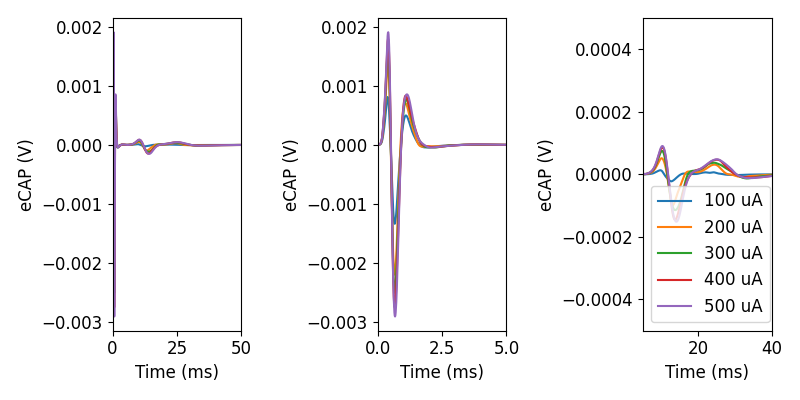

In [50]:
distanceIdx = 2

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

plt.figure(figsize=(8,4))

legend = []



for i in np.arange(5):
    
    plt.subplot(1,3,1)
    
    plt.plot(time[1:-1]*1e3,total1cm[i])
    
    plt.xlabel('Time (ms)')
    plt.ylabel('eCAP (V)')

    plt.xlim([0,50])
    plt.tight_layout()
    
    plt.subplot(1,3,2)
    
    plt.plot(time[1:-1]*1e3,total1cm[i])
    
    plt.xlabel('Time (ms)')
    plt.ylabel('eCAP (V)')

    plt.xlim([0,5])
    plt.tight_layout()
    
    plt.subplot(1,3,3)
    
    plt.plot(time[1:-1]*1e3,total1cm[i])
    legend.append(str(np.round(currents[i]))+' uA')
    
    plt.xlabel('Time (ms)')
    plt.ylabel('eCAP (V)')
    plt.legend(legend)

    plt.xlim([5,40])
    plt.ylim([-5e-4,5e-4])
    plt.tight_layout()
    
plt.savefig('figures/1cm.png',dpi=600)


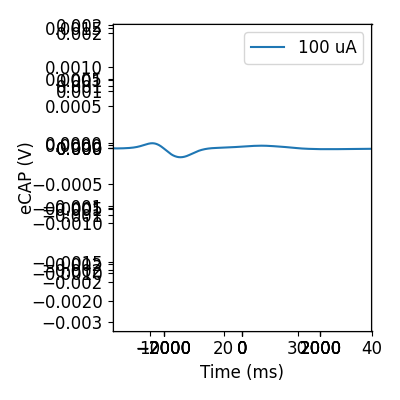

In [51]:
fig = plt.figure(figsize=(4,4))

legend = []

for i in range(5):

    ax = fig.add_subplot(111)
    
    plt.plot(time[1:-1]*1e3,total1cm[i])
    legend.append(str(currents[i])+' uA')
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([5,40])
plt.tight_layout()


# Gaussian jitter in recruitment curve
### Random variable added to the recruitment threshold for each fiber in the S4L model, with mean 10% to 40% of the threshold
### 500 uA current applied
### 6 cm distance between stimulus and recording electrodes

In [48]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_gaussian/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

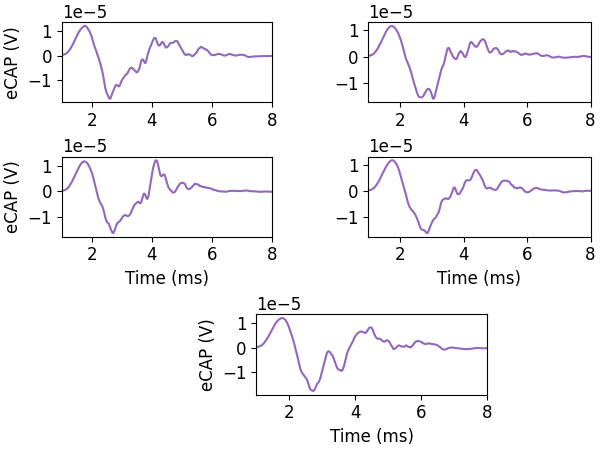

In [49]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,4.5),constrained_layout=True)

gs = GridSpec(3,6,figure=fig)
ax0 = fig.add_subplot(gs[0,:3])
ax1 = fig.add_subplot(gs[0,3:])
ax2 = fig.add_subplot(gs[1,:3])
ax3 = fig.add_subplot(gs[1,3:])
ax4 = fig.add_subplot(gs[2,2:5])

axes = [ax0,ax1,ax2,ax3,ax4]

legend = []

jitters = np.linspace(10,40,4)

for i in range(4):

    axes[i].plot(time[1:-1]*1e3,total6cm[i],c='tab:purple')
    
    # axes[i].set_title(str(jitters[i]) +'% jitter')
    axes[i].set_xlim([1,8])
    if i%2 == 0:
        axes[i].set_ylabel('eCAP (V)')
    if int(i/2)==1:
        axes[i].set_xlabel('Time (ms)')
    
    
ax4.plot(time[1:-1]*1e3,signals[-1],c='tab:purple')

# ax4.set_title('Reference Signal')
    
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('eCAP (V)')

ax4.set_xlim([1,8])

plt.savefig('figures/gaussian.png',dpi=600)

In [50]:
recruitmentGaussian = []
for i in range(39):
    recruitmentGaussian.append(np.load(outputfolder+'/'+str(0)+'/recruitment/recruitment_'+str(i)+'.npy',allow_pickle=True))
    

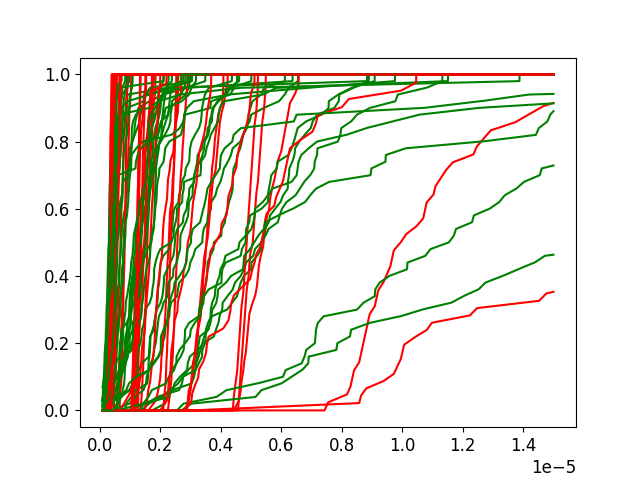

In [51]:
plt.figure()
for i in range(39):
    plt.plot(d,recruitment[i][-1][0],'r')
    plt.plot(d,recruitmentGaussian[i][-1][0],'g')

# Small cuff electrode covering only one side of the nerve
### 6 cm distance between stimulus and recording electrodes
### 12 mm separation between stimulus and recordign electrodes
### No gaussian jitter
### Signal plotted at 500 uA for both reference case and small electrode case

In [52]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

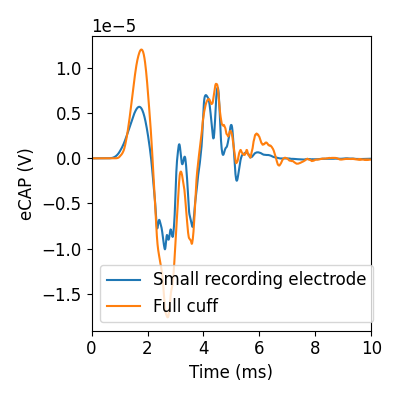

In [53]:
plt.figure(figsize=(4,4))


for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Small recording electrode','Full cuff'])

plt.xlim([0,10])
plt.tight_layout()

plt.savefig('figures/smallCuff.png',dpi=600)

# Same as above, but for recording electrode on opposite side of nerve

In [54]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec_otherside/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

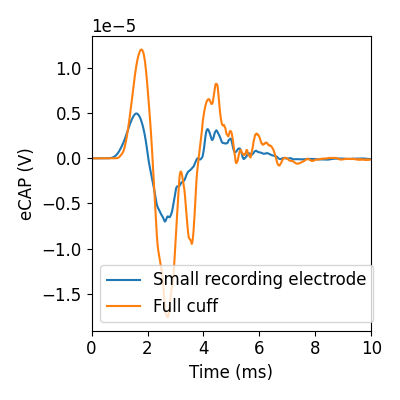

In [55]:
plt.figure(figsize=(4,4))


for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Small recording electrode','Full cuff'])

plt.xlim([0,10])
plt.tight_layout()

plt.savefig('figures/smallCuff2.png',dpi=600)

# Saves sensitivity magnitude for each fascicle as an RGB value

In [57]:
import matplotlib as mpl

CuffList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_20240213/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_Otherside_20240215/']


cmap = mpl.cm.ScalarMappable(cmap=mpl.colormaps['viridis'])

amps = []

recordingCurrents = [509e-6,250e-6,273e-6]

In [58]:


for i, c in enumerate(CuffList):
    for fascIdx in range(39):
        phi = pd.read_excel(c+str(fascIdx)+'_BetterConductivity.xlsx') 
        amp = np.max(phi.iloc[:,1])-np.min(phi.iloc[:,1])
        amps.append(amp/recordingCurrents[i])
        
rgb = cmap.to_rgba(amps)

np.save('figures/rgb.npy',rgb)


KeyboardInterrupt



### plots colorbar

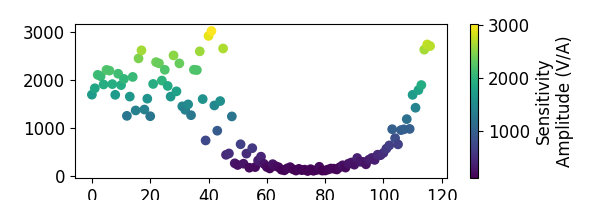

In [72]:
plt.figure(figsize=(6,2))
sc = plt.scatter(np.arange(39*3),amps,c=amps)
plt.colorbar(sc,label='Sensitivity\nAmplitude (V/A)')
plt.savefig('figures/smallCuffAll_colorbar.png',dpi=600)

# All three electrodes

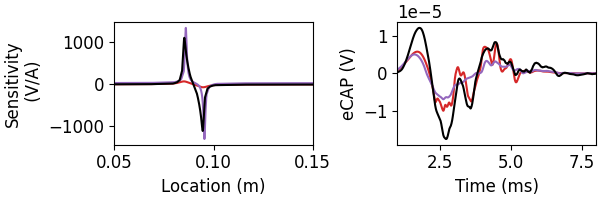

In [60]:
from matplotlib.gridspec import GridSpec

recordingCurrents = [250e-6,273e-6,509e-6]

fig = plt.figure(figsize=(6,2),constrained_layout=True)

gs = GridSpec(1,2,figure=fig)

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec_otherside/'

distanceIdx = 0

maff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm2 = maff6cm2 + meff6cm2 + uaff6cm2 + ueff6cm2

ax =  fig.add_subplot(gs[0,1])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,total6cm[-1],c='tab:red')
    ax.plot(time[1:-1]*1e3,total6cm2[-1],c='tab:purple')
    ax.plot(time[1:-1]*1e3,signals[-1],c='k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
# ax.legend(['Small, left', 'Small, right','Full cuff'],loc='right')
ax.set_xlim([1,8])


CuffList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_20240213/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Small_Otherside_20240215/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/PhiConductivity_Bipolar_Corrected/']



selectedFasc = [1,20,36]

colors = ['tab:red','tab:purple','k']

for i, cuff in enumerate(CuffList):

    if i == 0:
    
        newAx = fig.add_subplot(gs[0,0])
    
    for fascIdx in [selectedFasc[2]]:
        phi = pd.read_excel(cuff+str(fascIdx)+'_BetterConductivity.xlsx') 

        newAx.plot(phi.iloc[:,0], phi.iloc[:,1]/recordingCurrents[i],c=colors[i])

    newAx.set_ylabel('Sensitivity\n (V/A)')

    if i == 2:
        newAx.set_xlabel('Location (m)')

    newAx.set_xlim([0.05,0.15])
    
    
plt.savefig('figures/smallCuffAll.png',dpi=600)

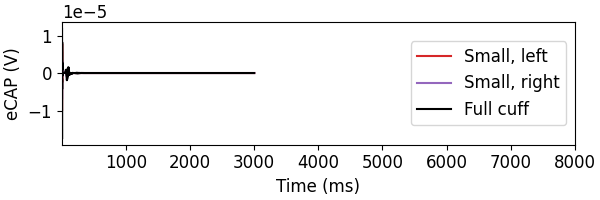

In [58]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,2),constrained_layout=True)

gs = GridSpec(1,1,figure=fig)

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_smallRec_otherside/'

distanceIdx = 0

maff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm2 = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm2 = maff6cm2 + meff6cm2 + uaff6cm2 + ueff6cm2

ax =  fig.add_subplot(gs[0,0])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,total6cm[-1],c='tab:red')
    ax.plot(time[1:-1]*1e3,total6cm2[-1],c='tab:purple')
    ax.plot(time[1:-1]*1e3,signals[-1],c='k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
ax.legend(['Small, left', 'Small, right','Full cuff'],loc='right')
ax.set_xlim([1,8000])


    
plt.savefig('figures/smallCuffAll_legend.png',dpi=600)

# 3 mm separation between recording electrodes instead of 12 mm
### No gaussian jitter
### 6 cm stimulus-recording separation

In [59]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_close/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm



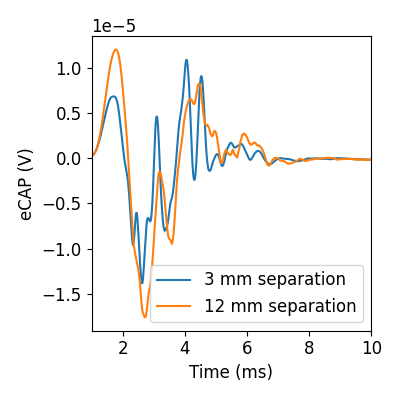

In [60]:
plt.figure(figsize=(4,4))

for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['3 mm separation','12 mm separation'])

plt.xlim([1,10])
plt.tight_layout()

plt.savefig('figures/3mmSeparation.png',dpi=600)

# Monopolar recordings
### 12 mm distance between the two cuff electrodes
### No gaussian jitter

In [61]:
outputfolderM = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar/'

distanceIdx = 0

maffM = np.load(outputfolderM+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffM = np.load(outputfolderM+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffM = np.load(outputfolderM+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffM = np.load(outputfolderM+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalM = maffM + meffM + uaffM + ueffM

outputfolderMf = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar_far/'

maffMf = np.load(outputfolderMf+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffMf = np.load(outputfolderMf+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffMf = np.load(outputfolderMf+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffMf = np.load(outputfolderMf+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalMf = maffMf + meffMf + uaffMf + ueffMf



### Plot eCAPs at 500 uA stimulus current

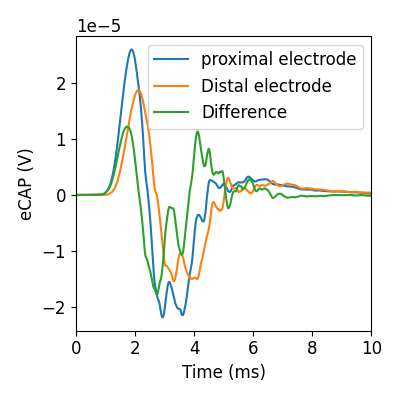

In [62]:
plt.figure(figsize=(4,4))

legend = ['proximal electrode','Distal electrode','Difference']
    
plt.plot(time[1:-1]*1e3,totalM[-1])
plt.plot(time[1:-1]*1e3,totalMf[-1])
plt.plot(time[1:-1]*1e3,totalM[-1]-totalMf[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(legend)

plt.xlim([0,10])
plt.tight_layout()

plt.savefig('figures/monopolar.png',dpi=600)

# Low perineurium conductivity
### 6 cm stimulus-recording separation
### 12 mm separation between cuff electrodes
### No gaussian jitter

In [63]:
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_lowConductivity/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

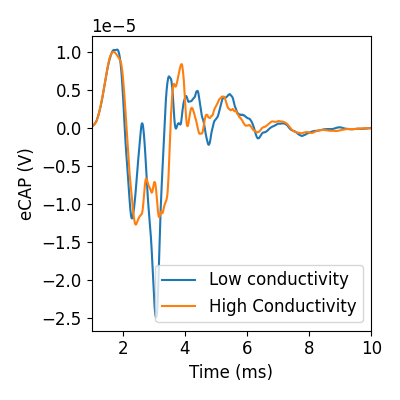

In [64]:
plt.figure(figsize=(4,4))

legend = []

for i in range(1):
    
    plt.plot(time[1:-1]*1e3,total6cm[-3])
    plt.plot(time[1:-1]*1e3,signals[-3])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Low conductivity','High Conductivity'])

plt.xlim([1,10])
plt.tight_layout()

plt.savefig('figures/lowConductivity.png',dpi=600)

# Vertical orientation of stimulation electrode
### High perineurium conductivity
### 12 mm separation between recording electrodes
### 6 cm separation between stimulus and recording electrodes

In [65]:
outputfolderD = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/'

distanceIdx = 0

maffD = np.load(outputfolderD+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffD = np.load(outputfolderD+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffD = np.load(outputfolderD+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffD = np.load(outputfolderD+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalD = maffD + meffD + uaffD + ueffD


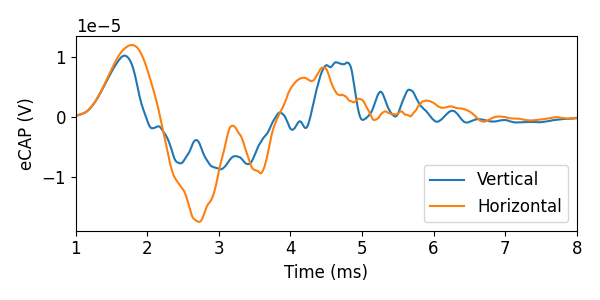

In [66]:
plt.figure(figsize=(6,3))

legend = []

for i in range(1):
    
    plt.plot(time[1:-1]*1e3,totalD[-1])
    plt.plot(time[1:-1]*1e3,signals[-1])
    
plt.xlabel('Time (ms)')
plt.ylabel('eCAP (V)')
plt.legend(['Vertical','Horizontal'])

plt.xlim([1,8])
plt.tight_layout()

plt.savefig('figures/vertical.png',dpi=600)

# Saves percent myelinated fiber activation for each fascicle as an RGB value

In [68]:
import matplotlib as mpl

stimList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/']


cmap = mpl.cm.ScalarMappable(cmap=mpl.colormaps['viridis'])

fractions = []

for s in stimList:
    for fascIdx in np.arange(39):
        
        recruitment = np.load(s+'/'+str(0)+'/recruitment/recruitment_'+str(fascIdx)+'.npy',allow_pickle=True)[-1][0]
        probs = np.load(s+'/'+str(0)+'/fascicles/probDist'+str(fascIdx)+'.npy',allow_pickle=True)
        pcts = np.load(s+'/'+str(0)+'/fascicles/probs'+str(fascIdx)+'.npy',allow_pickle=True)
        
        maff = probs[0]/(pcts[0]+pcts[1])
        meff = probs[1]/(pcts[0]+pcts[1])

        frac = np.sum(maff*recruitment+meff*recruitment)

        fractions.append(frac)
        
        
rgb = cmap.to_rgba(fractions)

np.save('figures/rgb_percentActivation.npy',rgb)

### Makes colorbar

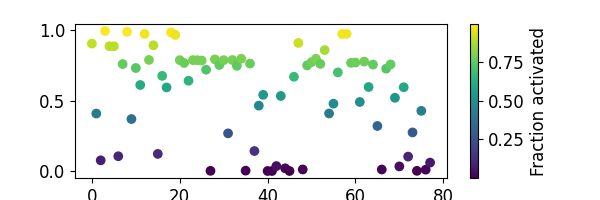

In [74]:
plt.figure(figsize=(6,2))
sc = plt.scatter(np.arange(2*39),fractions,c=fractions)
plt.colorbar(sc,label='Fraction activated')
    
plt.savefig('figures/verticalVhorizontal_colorbar.png',dpi=600)
plt.show()

### Random testing stuff

In [169]:
maffvals = np.loadtxt('/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/Data/maffvals.csv',delimiter=',')

In [173]:
from math import gamma

def gammaDist(x,k,theta):
    
    return 1 / (gamma(k)*theta**k) * x**(k-1)*np.exp(-x/theta)

In [174]:
from scipy.optimize import curve_fit

binSizeSamples = np.diff(d)[0]
    
empiricalDiams = maffvals[:,0]*1e-6 # From um to m
empiricalProbs = maffvals[:,1]*0.01 # From percentage to fraction

binSizeData = np.diff(empiricalDiams)[0] # Taking the first element ignores sloppy digitization towards the far end

binRatio = binSizeSamples/binSizeData

interp = interp1d(empiricalDiams,empiricalProbs,bounds_error=False,fill_value='extrapolate')

interpD = interp(d)

interpD[np.where(interpD<0)]=0
    
params = curve_fit(gammaDist,d*1e6,interpD*10,p0=[9,0.5])

interpD = gammaDist(d*1e6,params[0][0],params[0][1]) * 0.1


In [180]:
np.sum(interpD)

13.416096133659785

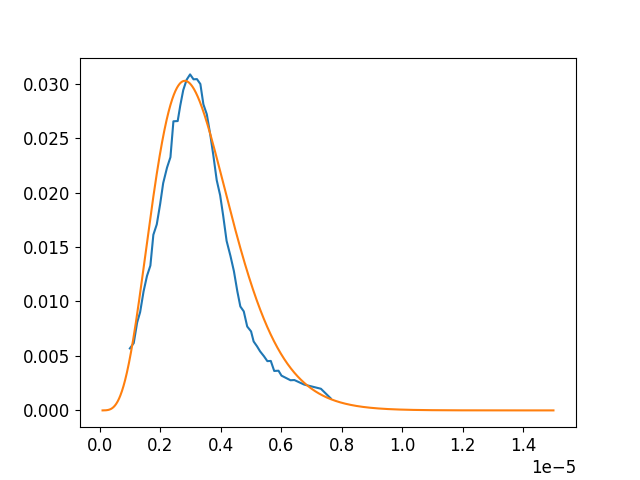

In [179]:
plt.figure()
plt.plot(empiricalDiams,empiricalProbs)
plt.plot(d,interpD)

In [75]:
np.sum(maff)

0.7858956630950124

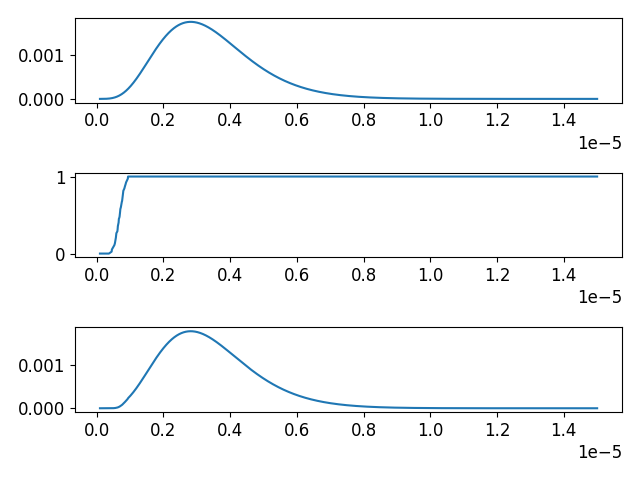

In [74]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(d,maff)
plt.subplot(3,1,2)
plt.plot(d,recruitment)
plt.subplot(3,1,3)
plt.plot(d,recruitment*maff)

plt.tight_layout()

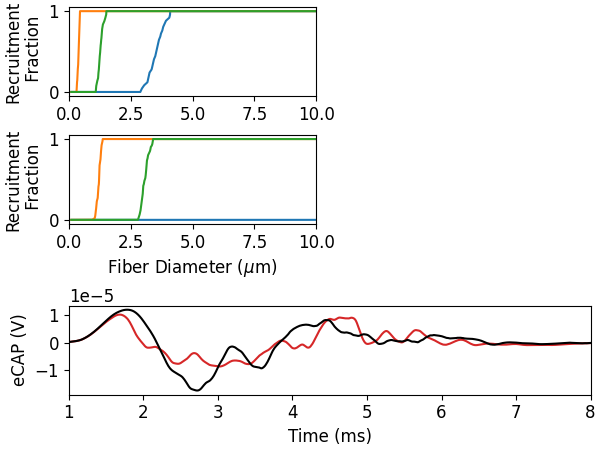

In [85]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,4.5),constrained_layout=True)

gs = GridSpec(3,2,figure=fig)

outputfolderD = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/'

distanceIdx = 0

maffD = np.load(outputfolderD+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffD = np.load(outputfolderD+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffD = np.load(outputfolderD+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffD = np.load(outputfolderD+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalD = maffD + meffD + uaffD + ueffD


ax =  fig.add_subplot(gs[2,:])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,totalD[-1],'tab:red')
    ax.plot(time[1:-1]*1e3,signals[-1],'k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
# ax.legend(['Vertical','Horizontal'],loc='right')
ax.set_xlim([1,8])


stimList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/']



selectedFasc = [1,20,36]

for i, stim in enumerate(stimList):
    
    newAx = fig.add_subplot(gs[i,0])
    
    for fascIdx in selectedFasc:
        recruitment = np.load(stim+'/'+str(0)+'/recruitment/recruitment_'+str(fascIdx)+'.npy',allow_pickle=True)

        newAx.plot(d*1e6,recruitment[-1][0])

    newAx.set_ylabel('Recruitment\n Fraction')

    if i == 1:
        newAx.set_xlabel('Fiber Diameter ($\mu$m)')

    newAx.set_xlim([0,10])
    
    
plt.savefig('figures/verticalVhorizontal.png',dpi=600)

## Same thing with legend

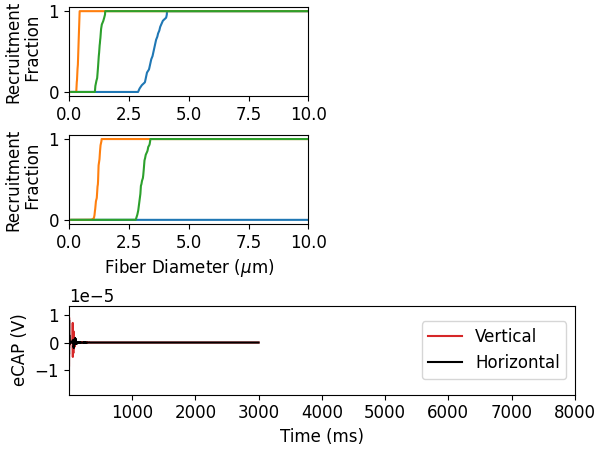

In [84]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,4.5),constrained_layout=True)

gs = GridSpec(3,2,figure=fig)

outputfolderD = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/'

distanceIdx = 0

maffD = np.load(outputfolderD+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffD = np.load(outputfolderD+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffD = np.load(outputfolderD+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffD = np.load(outputfolderD+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalD = maffD + meffD + uaffD + ueffD


ax =  fig.add_subplot(gs[2,:])

for i in range(1):
    
    ax.plot(time[1:-1]*1e3,totalD[-1],'tab:red')
    ax.plot(time[1:-1]*1e3,signals[-1],'k')
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('eCAP (V)')
ax.legend(['Vertical','Horizontal'],loc='right')
ax.set_xlim([1,8000])


stimList = ['/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/',
           '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_downward/']



selectedFasc = [1,20,36]

for i, stim in enumerate(stimList):
    
    newAx = fig.add_subplot(gs[i,0])
    
    for fascIdx in selectedFasc:
        recruitment = np.load(stim+'/'+str(0)+'/recruitment/recruitment_'+str(fascIdx)+'.npy',allow_pickle=True)

        newAx.plot(d*1e6,recruitment[-1][0])

    newAx.set_ylabel('Recruitment\n Fraction')

    if i == 1:
        newAx.set_xlabel('Fiber Diameter ($\mu$m)')

    newAx.set_xlim([0,10])
    
    
plt.savefig('figures/verticalVhorizontal_legend.png',dpi=600)

In [68]:
total1cm.shape

(5, 499997)

In [69]:
from scipy.io import loadmat



# Compare with in vivo data

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic-test//0/maff/0/signals.npy'

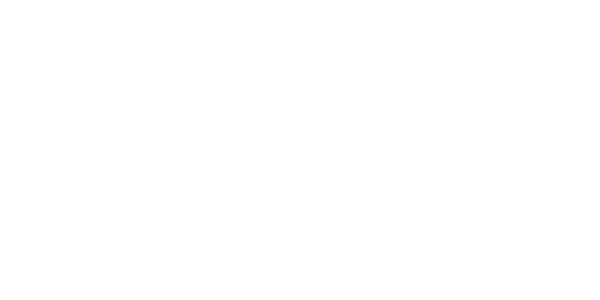

In [20]:
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

from scipy.io import loadmat

inVivoData = loadmat('/gpfs/bbp.cscs.ch/project/proj85/vagusNerve/vagusNerveCode/eCAPSdata_220303.mat')

a100 = list(inVivoData['eCAPSdata_220328'][0][-1])
a200 = list(inVivoData['eCAPSdata_220328'][0][-2])
a300 = list(inVivoData['eCAPSdata_220328'][0][-3])
a400 = list(inVivoData['eCAPSdata_220328'][0][-4])
a500 = list(inVivoData['eCAPSdata_220328'][0][-5])


outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic-test/'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

legend = []

# ax0 = fig.add_subplot(gs[0,:2])
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
# ax2 = fig.add_subplot(gs[0,2])
# ax4 = fig.add_subplot(gs[0,3])

ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
# ax6 = fig.add_subplot(gs[1,2])
# ax8 = fig.add_subplot(gs[1,3])


ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax0.plot(a100[2][0],a100[1][-1]-a100[1][0])
ax0.plot(a100[2][0],a200[1][-1]-a200[1][0])
ax0.plot(a100[2][0],a300[1][-1]-a300[1][0])
ax0.plot(a100[2][0],a400[1][-1]-a400[1][0])
ax0.plot(a100[2][0],a500[1][-1]-a500[1][0])

# plt.xlabel('Time (ms)')
ax0.set_ylabel('eCAP (V)')

ax0.set_xlim([1,8])
ax0.set_ylim([-3e-5,3e-5])




for i in np.arange(5):
    
    

    ax1.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax1.plot(time[1:-1]*1e3,total6cm[i])
    
    # plt.xlabel('Time (ms)')

    ax1.set_xlim([1,8])
    
    # ax2.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    # ax2.plot(time[1:-1]*1e3,total6cm[i])
    legend.append(str(np.round(currents[i]))+' uA')
    
    # # plt.xlabel('Time (ms)')
    # # plt.ylabel('eCAP (V)')
# ax1.legend(legend,loc='lower right')

    # ax2.set_xlim([10,200])
    # ax2.set_ylim([-5e-6,5e-6])

# 1 cm distance between stimulus and recording electrode
### Other parameters unchanged


distanceIdx = 2

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

inVivoData = loadmat('/gpfs/bbp.cscs.ch/project/proj85/vagusNerve/vagusNerveCode/eCAPSdata_220314.mat')

a100 = list(inVivoData['eCAPSdata_220314'][0][-1])
a200 = list(inVivoData['eCAPSdata_220314'][0][-2])
a300 = list(inVivoData['eCAPSdata_220314'][0][-3])
a400 = list(inVivoData['eCAPSdata_220314'][0][-4])
a500 = list(inVivoData['eCAPSdata_220314'][0][-5])

ax4.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax4.plot(a100[2][0],a100[1][-1]-a100[1][0])
ax4.plot(a100[2][0],a200[1][-1]-a200[1][0])
ax4.plot(a100[2][0],a300[1][-1]-a300[1][0])
ax4.plot(a100[2][0],a400[1][-1]-a400[1][0])
ax4.plot(a100[2][0],a500[1][-1]-a500[1][0])

ax4.set_ylabel('eCAP (V)')

ax4.set_xlim([0,20])
ax4.set_ylim([-3e-5,3e-5])

ax4.set_xlabel('Time (ms)')


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

for i in np.arange(5):
    
    ax5.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax5.plot(time[1:-1]*1e3,total1cm[i])
    
    # ax4.set_xlabel('Time (ms)')
    ax5.set_xlim([0,20])
    

    ax5.set_ylim([-3e-4,3e-4])

    ax5.set_xlabel('Time (ms)')

    
    # ax6.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    # ax6.plot(time[1:-1]*1e3,total1cm[i])
    # legend.append(str(np.round(currents[i]))+' uA')
    
    # # ax5.set_xlabel('Time (ms)')
    # # plt.ylabel('eCAP (V)')
    # # plt.legend(legend)

    # ax6.set_xlim([0,40])
    # ax6.set_ylim([-3e-4,3e-4])

# plt.savefig('figures/recordingfig/invivoFig.png',dpi=600)

### Same as above, but with legend

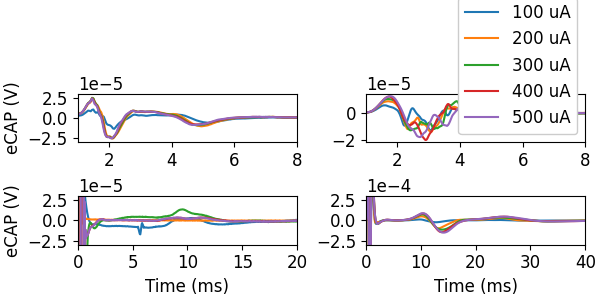

In [71]:
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

from scipy.io import loadmat

inVivoData = loadmat('/gpfs/bbp.cscs.ch/project/proj85/vagusNerve/vagusNerveCode/eCAPSdata_220303.mat')

a100 = list(inVivoData['eCAPSdata_220328'][0][-1])
a200 = list(inVivoData['eCAPSdata_220328'][0][-2])
a300 = list(inVivoData['eCAPSdata_220328'][0][-3])
a400 = list(inVivoData['eCAPSdata_220328'][0][-4])
a500 = list(inVivoData['eCAPSdata_220328'][0][-5])


outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(2,2,figure=fig)

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

legend = []

# ax0 = fig.add_subplot(gs[0,:2])
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
# ax2 = fig.add_subplot(gs[0,2])
# ax4 = fig.add_subplot(gs[0,3])

ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
# ax6 = fig.add_subplot(gs[1,2])
# ax8 = fig.add_subplot(gs[1,3])


ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax0.plot(a100[2][0],a100[1][-1]-a100[1][0])
ax0.plot(a100[2][0],a200[1][-1]-a200[1][0])
ax0.plot(a100[2][0],a300[1][-1]-a300[1][0])
ax0.plot(a100[2][0],a400[1][-1]-a400[1][0])
ax0.plot(a100[2][0],a500[1][-1]-a500[1][0])

# plt.xlabel('Time (ms)')
ax0.set_ylabel('eCAP (V)')

ax0.set_xlim([1,8])
ax0.set_ylim([-3e-5,3e-5])




for i in np.arange(5):
    
    

    ax1.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax1.plot(time[1:-1]*1e3,total6cm[i])
    
    # plt.xlabel('Time (ms)')

    ax1.set_xlim([1,8])
    
    # ax2.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    # ax2.plot(time[1:-1]*1e3,total6cm[i])
    legend.append(str(np.round(currents[i]))+' uA')
    
    # # plt.xlabel('Time (ms)')
    # # plt.ylabel('eCAP (V)')
ax1.legend(legend,loc='lower right',framealpha=1)

    # ax2.set_xlim([10,200])
    # ax2.set_ylim([-5e-6,5e-6])

# 1 cm distance between stimulus and recording electrode
### Other parameters unchanged


distanceIdx = 2

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

inVivoData = loadmat('/gpfs/bbp.cscs.ch/project/proj85/vagusNerve/vagusNerveCode/eCAPSdata_220314.mat')

a100 = list(inVivoData['eCAPSdata_220314'][0][-1])
a200 = list(inVivoData['eCAPSdata_220314'][0][-2])
a300 = list(inVivoData['eCAPSdata_220314'][0][-3])
a400 = list(inVivoData['eCAPSdata_220314'][0][-4])
a500 = list(inVivoData['eCAPSdata_220314'][0][-5])

ax4.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

ax4.plot(a100[2][0],a100[1][-1]-a100[1][0])
ax4.plot(a100[2][0],a200[1][-1]-a200[1][0])
ax4.plot(a100[2][0],a300[1][-1]-a300[1][0])
ax4.plot(a100[2][0],a400[1][-1]-a400[1][0])
ax4.plot(a100[2][0],a500[1][-1]-a500[1][0])

ax4.set_ylabel('eCAP (V)')

ax4.set_xlim([0,20])
ax4.set_ylim([-3e-5,3e-5])

ax4.set_xlabel('Time (ms)')


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

for i in np.arange(5):
    
    ax5.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax5.plot(time[1:-1]*1e3,total1cm[i])
    
    # ax4.set_xlabel('Time (ms)')
    ax5.set_xlim([0,40])
    

    ax5.set_ylim([-3e-4,3e-4])

    ax5.set_xlabel('Time (ms)')

    
    # ax6.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    # ax6.plot(time[1:-1]*1e3,total1cm[i])
    # legend.append(str(np.round(currents[i]))+' uA')
    
    # # ax5.set_xlabel('Time (ms)')
    # # plt.ylabel('eCAP (V)')
    # # plt.legend(legend)

    # ax6.set_xlim([0,40])
    # ax6.set_ylim([-3e-4,3e-4])

plt.savefig('figures/recordingfig/invivoFig_legend.png',dpi=600)

# Recording electrode configuration Figure

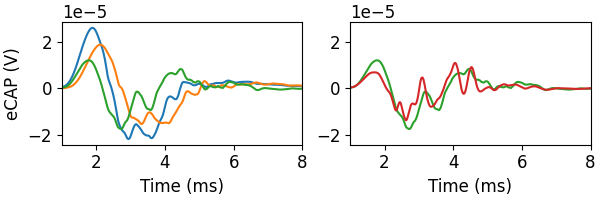

In [72]:
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,2),constrained_layout=True)

gs = GridSpec(1,2,figure=fig)

distanceIdx = 0

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

legend = ['12 mm','3 mm']


# 3 mm separation between recording electrodes instead of 12 mm
### No gaussian jitter
### 6 cm stimulus-recording separation
    
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_close/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

ax0 = fig.add_subplot(gs[0,1])
ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

for i in range(1):

    ax0.plot(time[1:-1]*1e3,signals[-1],c='C2')
    
    ax0.plot(time[1:-1]*1e3,total6cm[-1],c='C3')
    
    
ax0.set_xlabel('Time (ms)')
# ax0.set_ylabel('eCAP (V)')
# ax0.legend(legend,loc='right',handlelength=.5)
ax0.set_xlim([1,8])

# Fascicles plotted in for both distances
### No gaussian jitter
### 6 cm stimulus-recording separation

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/'

outputfolderClose = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_close/'

fascSignals = []


# ax1 = fig.add_subplot(gs[0,3:])

# for fascicle in np.arange(1,2):

#     distanceIdx = 0

#     maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')
#     meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')

#     maff6cmC = np.load(outputfolderClose+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')
#     meff6cmC = np.load(outputfolderClose+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')

#     ax1.plot(time[1:-1]*1e3,maff6cm[-1] + meff6cm[-1],c='b')
#     ax1.plot(time[1:-1]*1e3,maff6cmC[-1] + meff6cmC[-1],c='r')

# ax1.set_xlim([1,8])
# ax1.legend(legend,loc='right',handlelength=.5)
# ax1.set_xlabel('Time (ms)')

# Monopolar recordings
### 12 mm distance between the two cuff electrodes
### No gaussian jitter

outputfolderM = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar/'

distanceIdx = 0

maffM = np.load(outputfolderM+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffM = np.load(outputfolderM+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffM = np.load(outputfolderM+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffM = np.load(outputfolderM+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalM = maffM + meffM + uaffM + ueffM

outputfolderMf = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar_far/'

maffMf = np.load(outputfolderMf+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffMf = np.load(outputfolderMf+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffMf = np.load(outputfolderMf+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffMf = np.load(outputfolderMf+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalMf = maffMf + meffMf + uaffMf + ueffMf


ax7 = fig.add_subplot(gs[0,0],sharey=ax0)
ax7.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
# legend = ['Proximal monopolar','Distal monopolar','Bipolar']
    
ax7.plot(time[1:-1]*1e3,totalM[-1])
ax7.plot(time[1:-1]*1e3,totalMf[-1])
ax7.plot(time[1:-1]*1e3,signals[-1])
    
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('eCAP (V)')
# plt.legend(legend,handlelength=.5)

ax7.set_xlim([1,8])



plt.savefig('figures/recordingfig/recordingfig.png',dpi=600)

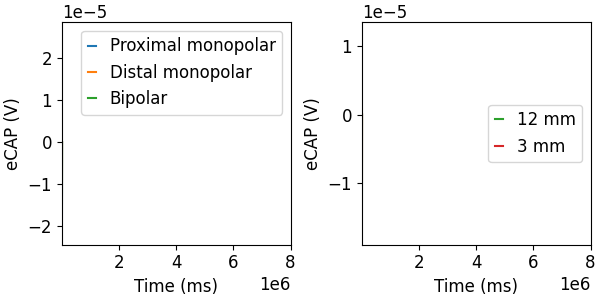

In [73]:
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,3),constrained_layout=True)

gs = GridSpec(1,2,figure=fig)

distanceIdx = 0

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

legend = ['12 mm','3 mm']


# 3 mm separation between recording electrodes instead of 12 mm
### No gaussian jitter
### 6 cm stimulus-recording separation
    
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_close/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

ax0 = fig.add_subplot(gs[0,1])
ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

for i in range(1):

    ax0.plot(time[1:-1]*1e3,signals[-1],c='C2')
    
    ax0.plot(time[1:-1]*1e3,total6cm[-1],c='C3')
    
    
ax0.set_xlabel('Time (ms)')
ax0.set_ylabel('eCAP (V)')
ax0.legend(legend,loc='right',handlelength=.5)
ax0.set_xlim([1,8000000])

# Fascicles plotted in for both distances
### No gaussian jitter
### 6 cm stimulus-recording separation

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/'

outputfolderClose = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_close/'

fascSignals = []


# ax1 = fig.add_subplot(gs[0,3:])

# for fascicle in np.arange(1,2):

#     distanceIdx = 0

#     maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')
#     meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')

#     maff6cmC = np.load(outputfolderClose+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')
#     meff6cmC = np.load(outputfolderClose+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals_'+str(fascicle)+'.npy')

#     ax1.plot(time[1:-1]*1e3,maff6cm[-1] + meff6cm[-1],c='b')
#     ax1.plot(time[1:-1]*1e3,maff6cmC[-1] + meff6cmC[-1],c='r')

# ax1.set_xlim([1,8])
# ax1.legend(legend,loc='right',handlelength=.5)
# ax1.set_xlabel('Time (ms)')

# Monopolar recordings
### 12 mm distance between the two cuff electrodes
### No gaussian jitter

outputfolderM = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar/'

distanceIdx = 0

maffM = np.load(outputfolderM+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffM = np.load(outputfolderM+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffM = np.load(outputfolderM+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffM = np.load(outputfolderM+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalM = maffM + meffM + uaffM + ueffM

outputfolderMf = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar_far/'

maffMf = np.load(outputfolderMf+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffMf = np.load(outputfolderMf+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffMf = np.load(outputfolderMf+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffMf = np.load(outputfolderMf+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalMf = maffMf + meffMf + uaffMf + ueffMf


ax7 = fig.add_subplot(gs[0,0])
ax7.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
legend = ['Proximal monopolar','Distal monopolar','Bipolar']
    
ax7.plot(time[1:-1]*1e3,totalM[-1])
ax7.plot(time[1:-1]*1e3,totalMf[-1])
ax7.plot(time[1:-1]*1e3,totalM[-1]-totalMf[-1])
    
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('eCAP (V)')
plt.legend(legend,handlelength=.5)

ax7.set_xlim([1,8000000])


plt.savefig('figures/recordingfig/recordingfig_legend.png',dpi=600)

# Plots legends for big figure

IndexError: index 6 is out of bounds for axis 0 with size 5

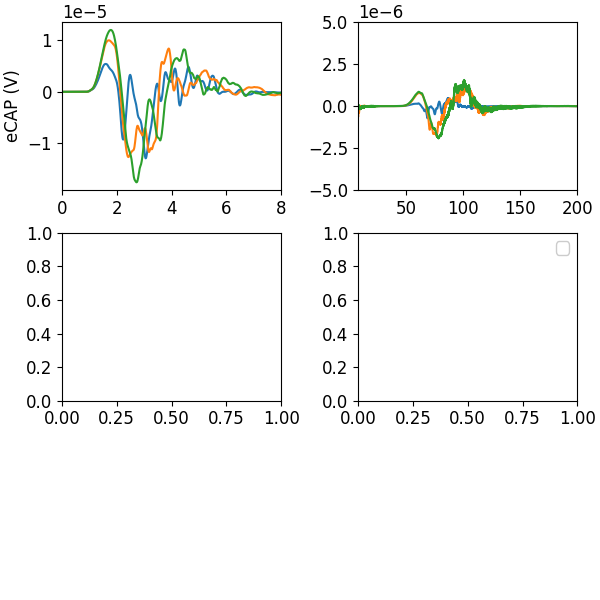

In [74]:
# 6 cm distance between stimulus and recording electrode
### Other parameters unchanged

outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic/'

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(6,6),constrained_layout=True)

gs = GridSpec(3,6,figure=fig)

distanceIdx = 0

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

legend = []

# ax0 = fig.add_subplot(gs[0,:2])
ax1 = fig.add_subplot(gs[0,0:3])
ax2 = fig.add_subplot(gs[0,3:])

# ax3 = fig.add_subplot(gs[1,:2])
ax4 = fig.add_subplot(gs[1,0:3])
ax5 = fig.add_subplot(gs[1,3:])


for i in np.arange(0,10,2):
    
    
    # ax0.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    # ax0.plot(time[1:-1]*1e3,total1cm[i])
    
    # # plt.xlabel('Time (ms)')
    # ax0.set_ylabel('eCAP (V)')

    # ax0.set_xlim([0,50])
    
    ax1.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax1.plot(time[1:-1]*1e3,total1cm[i])
    
    # plt.xlabel('Time (ms)')
    ax1.set_ylabel('eCAP (V)')

    ax1.set_xlim([0,8])
    
    ax2.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax2.plot(time[1:-1]*1e3,total1cm[i])
    legend.append(str(np.round(currents[i]))+' uA')
    
    # plt.xlabel('Time (ms)')
    # plt.ylabel('eCAP (V)')
    plt.legend(legend,framealpha=1)

    ax2.set_xlim([8,200])
    ax2.set_ylim([-5e-6,5e-6])

# 1 cm distance between stimulus and recording electrode
### Other parameters unchanged


distanceIdx = 2

maff1cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff1cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff1cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff1cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 


total1cm = maff1cm + meff1cm + uaff1cm + ueff1cm

legend = []


for i in np.arange(0,10,2):
    
    # ax3.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    # ax3.plot(time[1:-1]*1e3,total1cm[i])
    
    # ax3.set_xlabel('Time (ms)')
    # ax3.set_ylabel('eCAP (V)')

    # ax3.set_xlim([0,50])
    
    ax4.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax4.plot(time[1:-1]*1e3,total1cm[i])
    
    ax4.set_xlabel('Time (ms)')
    ax4.set_xlim([0,8])
    
    # ax4.set_ylabel('eCAP (V)')

    
    ax5.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
    
    ax5.plot(time[1:-1]*1e3,total1cm[i])
    legend.append(str(np.round(currents[i]))+' uA')
    
    # ax5.set_xlabel('Time (ms)')
    # plt.ylabel('eCAP (V)')
    plt.legend(legend,framealpha=1)

    ax5.set_xlim([8,40])
    ax5.set_ylim([-5e-4,5e-4])

# 3 mm separation between recording electrodes instead of 12 mm
### No gaussian jitter
### 6 cm stimulus-recording separation
    
outputfolder = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_close/'

distanceIdx = 0

maff6cm = np.load(outputfolder+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meff6cm = np.load(outputfolder+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaff6cm = np.load(outputfolder+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueff6cm = np.load(outputfolder+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

total6cm = maff6cm + meff6cm + uaff6cm + ueff6cm

ax6 = fig.add_subplot(gs[2,:3])
ax6.ticklabel_format(style='sci',axis='y',scilimits=(0,0))

for i in range(1):
    
    ax6.plot(time[1:-1]*1e3,total6cm[-1])
    ax6.plot(time[1:-1]*1e3,signals[-1])
    
ax6.set_xlabel('Time (ms)')
ax6.set_ylabel('eCAP (V)')
plt.legend(['3 mm separation','12 mm separation'],framealpha=1)

ax6.set_xlim([0,8])


# Monopolar recordings
### 12 mm distance between the two cuff electrodes
### No gaussian jitter

outputfolderM = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar/'

distanceIdx = 0

maffM = np.load(outputfolderM+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffM = np.load(outputfolderM+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffM = np.load(outputfolderM+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffM = np.load(outputfolderM+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalM = maffM + meffM + uaffM + ueffM

outputfolderMf = '/gpfs/bbp.cscs.ch/project/proj85/scratch/vagusNerve/results/finalResults/Analytic_monopolar_far/'

maffMf = np.load(outputfolderMf+'/'+str(iteration)+'/maff/'+str(distanceIdx)+'/signals.npy')
meffMf = np.load(outputfolderMf+'/'+str(iteration)+'/meff/'+str(distanceIdx)+'/signals.npy')
uaffMf = np.load(outputfolderMf+'/'+str(iteration)+'/uaff/'+str(distanceIdx)+'/signals.npy')
ueffMf = np.load(outputfolderMf+'/'+str(iteration)+'/ueff/'+str(distanceIdx)+'/signals.npy') 

totalMf = maffMf + meffMf + uaffMf + ueffMf


ax7 = fig.add_subplot(gs[2,3:])
ax7.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
legend = ['Proximal electrode','Distal electrode','Difference']
    
ax7.plot(time[1:-1]*1e3,totalM[-1])
ax7.plot(time[1:-1]*1e3,totalMf[-1])
ax7.plot(time[1:-1]*1e3,totalM[-1]-totalMf[-1])
    
ax7.set_xlabel('Time (ms)')
# plt.ylabel('eCAP (V)')
plt.legend(legend,framealpha=1)

ax7.set_xlim([0,8])

plt.savefig('figures/recordingfig/legends.png',dpi=600)